Data Description for this data set  

In this competition you will predict the speed at which a pet is adopted, based on the pet’s listing on PetFinder. Sometimes a profile represents a group of pets. In this case, the speed of adoption is determined by the speed at which all of the pets are adopted. The data included text, tabular, and image data. See below for details. 
This is a Kernels-only competition. At the end of the competition, test data will be replaced in their entirety with new data of approximately the same size, and your kernels will be rerun on the new data.



File descriptions
train.csv - Tabular/text data for the training set
test.csv - Tabular/text data for the test set
sample_submission.csv - A sample submission file in the correct format
breed_labels.csv - Contains Type, and BreedName for each BreedID. Type 1 is dog, 2 is cat.
color_labels.csv - Contains ColorName for each ColorID
state_labels.csv - Contains StateName for each StateID

Data Fields
PetID - Unique hash ID of pet profile

AdoptionSpeed - Categorical speed of adoption. Lower is faster. This is the value to predict. See below section for more info.

Type - Type of animal (1 = Dog, 2 = Cat)

Name - Name of pet (Empty if not named)

Age - Age of pet when listed, in months

Breed1 - Primary breed of pet (Refer to BreedLabels dictionary)

Breed2 - Secondary breed of pet, if pet is of mixed breed (Refer to BreedLabels dictionary)

Gender - Gender of pet (1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets)

Color1 - Color 1 of pet (Refer to ColorLabels dictionary)

Color2 - Color 2 of pet (Refer to ColorLabels dictionary)

Color3 - Color 3 of pet (Refer to ColorLabels dictionary)

MaturitySize - Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)

FurLength - Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)

Vaccinated - Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)

Dewormed - Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)

Sterilized - Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)

Health - Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)

Quantity - Number of pets represented in profile

Fee - Adoption fee (0 = Free)

State - State location in Malaysia (Refer to StateLabels dictionary)

RescuerID - Unique hash ID of rescuer
VideoAmt - Total uploaded videos for this pet
PhotoAmt - Total uploaded photos for this pet
Description - Profile write-up for this pet. The primary language used is English, with some in Malay or Chinese.

AdoptionSpeed (Target)
Contestants are required to predict this value. The value is determined by how quickly, if at all, a pet is adopted. The values are determined in the following way: 
0 - Pet was adopted on the same day as it was listed. 
1 - Pet was adopted between 1 and 7 days (1st week) after being listed. 
2 - Pet was adopted between 8 and 30 days (1st month) after being listed. 
3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed. 
4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days).

In [12]:
# Libraries to be imported for EDA 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Text Analysis
import nltk
import re
import csv
from tqdm import tqdm
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer

## Regression Models
from sklearn.naive_bayes import MultinomialNB
from featexp import get_univariate_plots
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy import stats
import missingno as msno
from sklearn.metrics import confusion_matrix, classification_report
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

## Models for Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Lifeline Models
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines import NelsonAalenFitter


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [13]:
## References
## https://raiswell.rbind.io/post/one-way-anova-in-python/
## https://pythonfordatascience.org/anova-python/
## https://blog.datarobot.com/ordinary-least-squares-in-python

In [14]:
# Importing the original Petfinders dataset
data_r = pd.read_csv('C:/Users/jlpar/Documents/Springboard Curriculum/Projects/Capsone Project Ideas/Capstone Data/Pet Adoption/train.csv')
print(type(data_r))

<class 'pandas.core.frame.DataFrame'>


In [15]:
# Quick Column Visualization
data_r.tail(-1)

Type                                 Name  Age  Breed1  Breed2  Gender  \
1         2                          No Name Yet    1     265       0       1   
2         1                               Brisco    1     307       0       1   
3         1                                 Miko    4     307       0       2   
4         1                               Hunter    1     307       0       1   
5         2                                  NaN    3     266       0       2   
6         2                                BULAT   12     264     264       1   
7         1              Siu Pak & Her 6 Puppies    0     307       0       2   
8         2                                  NaN    2     265       0       2   
9         2                                Kitty   12     265       0       2   
10        1                                 Bear    2     307       0       1   
11        2                                 Kali    3     264       0       2   
12        1                               Peanut    2     307       0       1   
13        2              2 Mths Old Cute Kitties    2     265       0       3   
14        1                             Lost Dog    3     307       0       2   
15        1                                  Max   78     218     205       1   
16        2                              Brownie    6     266       0       2   
17        1                              Blackie    8     307     307       2   
18        1                               Beauty    2     307       0       2   
19        2                                  NaN    1     266       0       3   
20        1                               Godiva   12     307       0       2   
21        1                               Tigers    3     307       0       2   
22        2    Kenit, Kenot, Techit, Keyad, Owen    0     114       0       3   
23        1                                Donut   10     307     117       2   
24        2                              Cikenet    3     266       0       1   
25        2                             Garfield   36     285     251       1   
26        2                              No Name    2     285     265       1   
27        2                              No Name    1     266       0       2   
28        1                               Hunter   14     189       0       1   
29        2                               Pepper    1     266       0       2   
30        1                         Benji & Kimi    4     205     218       3   
...     ...                                  ...  ...     ...     ...     ...   
14963     2                              Boceyyy    6     276       0       1   
14964     2                                Panbe   36     265       0       1   
14965     2                                Manis    2     266       0       2   
14966     2                               Belang    1     265       0       1   
14967     2                              Doremon   24     265       0       2   
14968     2                      Sentul Kittiens    2     266       0       3   
14969     2                               Tommie   10     266       0       1   
14970     1              KL Puppies For Adoption    2     307       0       2   
14971     2                                Omari    5     265       0       1   
14972     2                         Kofi (annan)    2     266       0       1   
14973     1                                 Zee4    2     307     307       2   
14974     1                              Ang Ang    2     307       0       1   
14975     1                               Wormmy   24     307       0       2   
14976     2                        Cici N Shelly   84     264     264       3   
14977     2                               Kimchi    3     254       0       2   
14978     1                                Ethio    4     307       0       2   
14979     1                             SambaBoy    6     307       0       1   
14980     1                           

In [16]:
# Looking at the names of the columns
data_r.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed'],
      dtype='object')

In [17]:
# Shape of the rows and columns for the raw data set 
nrow, ncol = data_r.shape
nrow, ncol

(14993, 24)

In [18]:
# Description of the all the attributes which inludes non numeric ones
data_r.describe(include='all')

Type   Name           Age        Breed1        Breed2  \
count   14993.000000  13736  14993.000000  14993.000000  14993.000000   
unique           NaN   9060           NaN           NaN           NaN   
top              NaN   Baby           NaN           NaN           NaN   
freq             NaN     66           NaN           NaN           NaN   
mean        1.457614    NaN     10.452078    265.272594     74.009738   
std         0.498217    NaN     18.155790     60.056818    123.011575   
min         1.000000    NaN      0.000000      0.000000      0.000000   
25%         1.000000    NaN      2.000000    265.000000      0.000000   
50%         1.000000    NaN      3.000000    266.000000      0.000000   
75%         2.000000    NaN     12.000000    307.000000    179.000000   
max         2.000000    NaN    255.000000    307.000000    307.000000   

              Gender        Color1        Color2        Color3  MaturitySize  \
count   14993.000000  14993.000000  14993.000000  14993.000000  14993.000000   
unique           NaN           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN           NaN   
mean        1.776162      2.234176      3.222837      1.882012      1.862002   
std         0.681592      1.745225      2.742562      2.984086      0.547959   
min         1.000000      1.000000      0.000000      0.000000      1.000000   
25%         1.000000      1.000000      0.000000      0.000000      2.000000   
50%         2.000000      2.000000      2.000000      0.000000      2.000000   
75%         2.000000      3.000000      6.000000      5.000000      2.000000   
max         3.000000      7.000000      7.000000      7.000000      4.000000   

            ...              Health      Quantity           Fee         State  \
count       ...        14993.000000  14993.000000  14993.000000  14993.000000   
unique      ...                 NaN           NaN           NaN           NaN   
top         ...                 NaN           NaN           NaN           NaN   
freq        ...                 NaN           NaN           NaN           NaN   
mean        ...            1.036617      1.576069     21.259988  41346.028347   
std         ...            0.199535      1.472477     78.414548     32.444153   
min         ...            1.000000      1.000000      0.000000  41324.000000   
25%         ...            1.000000      1.000000      0.000000  41326.000000   
50%         ...            1.000000      1.000000      0.000000  41326.000000   
75%         ...            1.000000      1.000000      0.000000  41401.000000   
max         ...            3.000000     20.000000   3000.000000  41415.000000   

                               RescuerID      VideoAmt   Description  \
count                              14993  14993.000000         14981   
unique                              5595           NaN         14032   
top     fa90fa5b1ee11c86938398b60abc32cb           NaN  For Adoption   
freq                                 459           NaN           164   
mean                                 NaN      0.056760           NaN   
std                                  NaN      0.346185           NaN   
min                                  NaN      0.000000           NaN   
25%                                  NaN      0.000000           NaN   
50%                                  NaN      0.000000           NaN   
75%                                  NaN      0.000000           NaN   
max                                  NaN      8.000000           NaN   

            PetID      PhotoAmt  AdoptionSpeed  
count       14993  14993.000000   14993.000000  
unique      14993           NaN            NaN  
top     a9e753cc1           NaN            NaN  
freq            1           NaN            NaN  
mean          NaN      3.889215       2.516441  
std           NaN      3.487810       1.177265

In [19]:
# Information for the raw dataset 
data_r.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 24 columns):
Type             14993 non-null int64
Name             13736 non-null object
Age              14993 non-null int64
Breed1           14993 non-null int64
Breed2           14993 non-null int64
Gender           14993 non-null int64
Color1           14993 non-null int64
Color2           14993 non-null int64
Color3           14993 non-null int64
MaturitySize     14993 non-null int64
FurLength        14993 non-null int64
Vaccinated       14993 non-null int64
Dewormed         14993 non-null int64
Sterilized       14993 non-null int64
Health           14993 non-null int64
Quantity         14993 non-null int64
Fee              14993 non-null int64
State            14993 non-null int64
RescuerID        14993 non-null object
VideoAmt         14993 non-null int64
Description      14981 non-null object
PetID            14993 non-null object
PhotoAmt         14993 non-null float64
AdoptionSpe

In [20]:
## Pandas Profiling to get another view from the data set
import pandas_profiling
pandas_profiling.ProfileReport(data_r)

In [21]:
## Exporing Pandas Profile
profile = pandas_profiling.ProfileReport(data_r)
profile.to_file(outputfile="Downloads/report.html")

                                            Plots for Type                                            


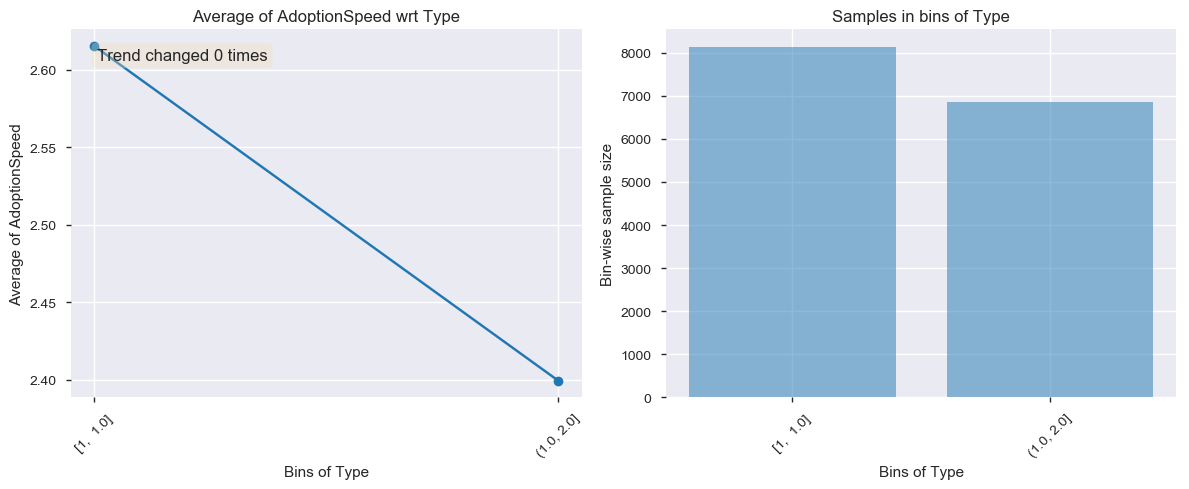

--------------------------------------------------------------------------------------------------------------


                                            Plots for Age                                             


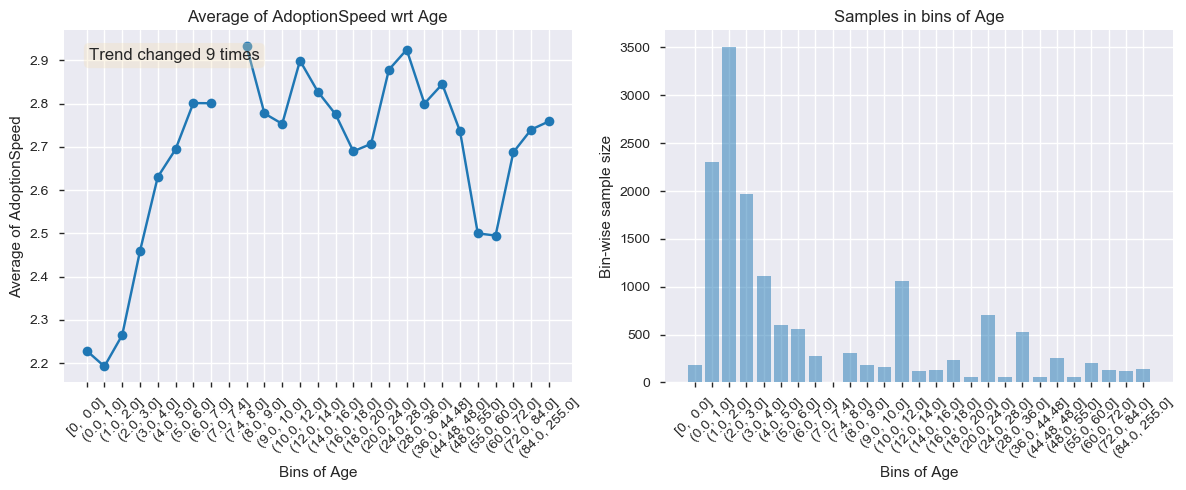

--------------------------------------------------------------------------------------------------------------


                                           Plots for Breed1                                           


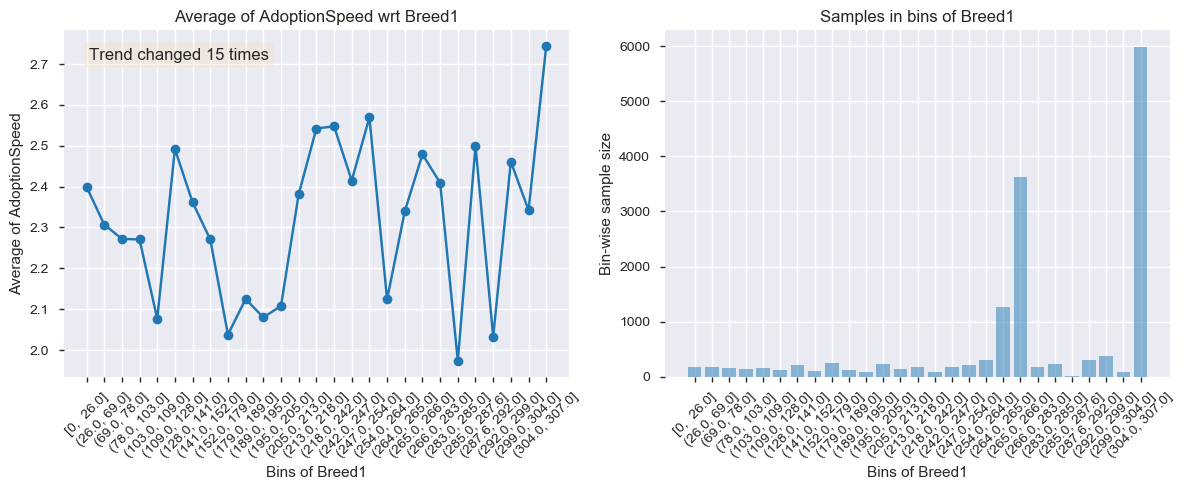

--------------------------------------------------------------------------------------------------------------


                                           Plots for Breed2                                           


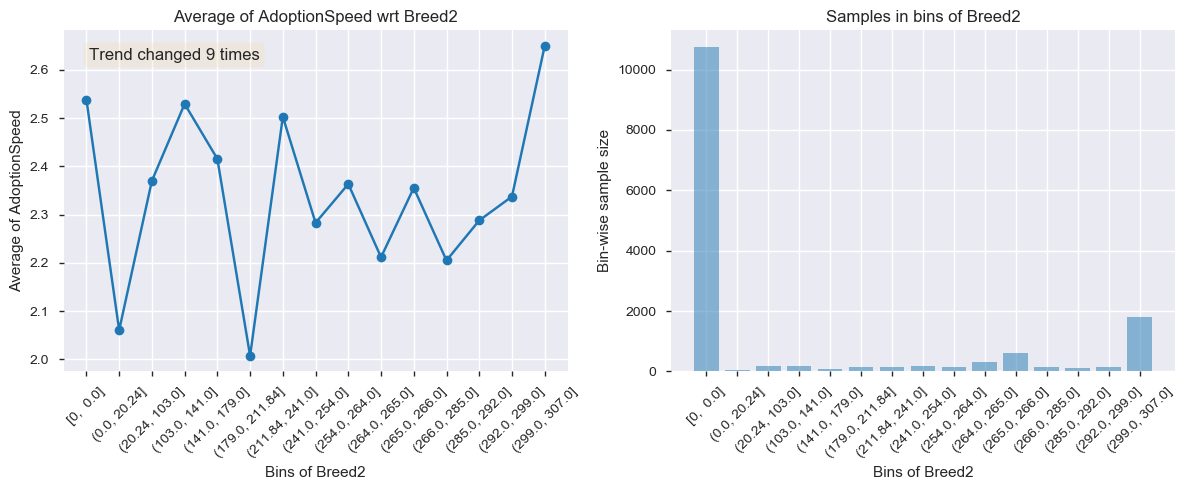

--------------------------------------------------------------------------------------------------------------


                                           Plots for Gender                                           


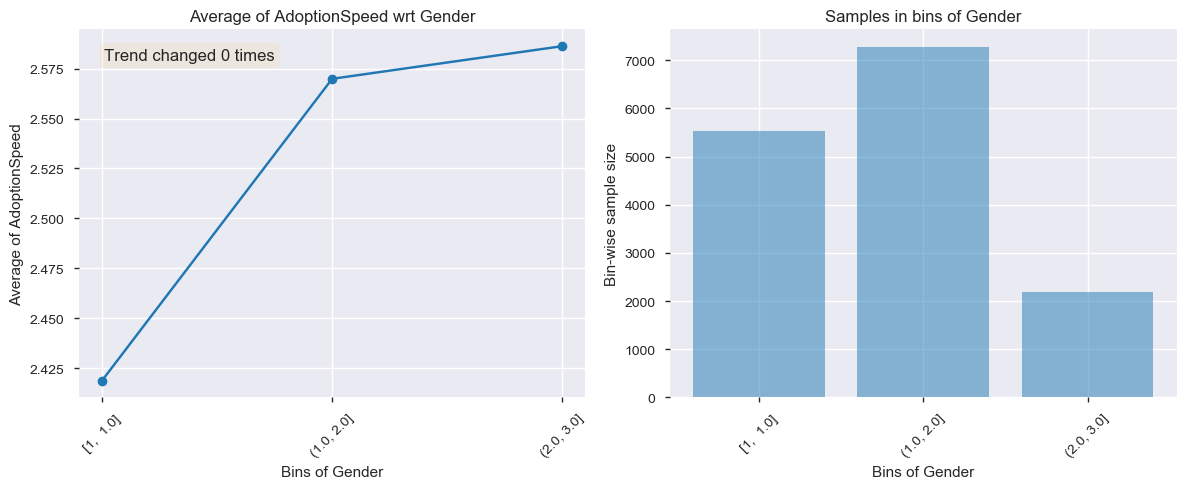

--------------------------------------------------------------------------------------------------------------


                                           Plots for Color1                                           


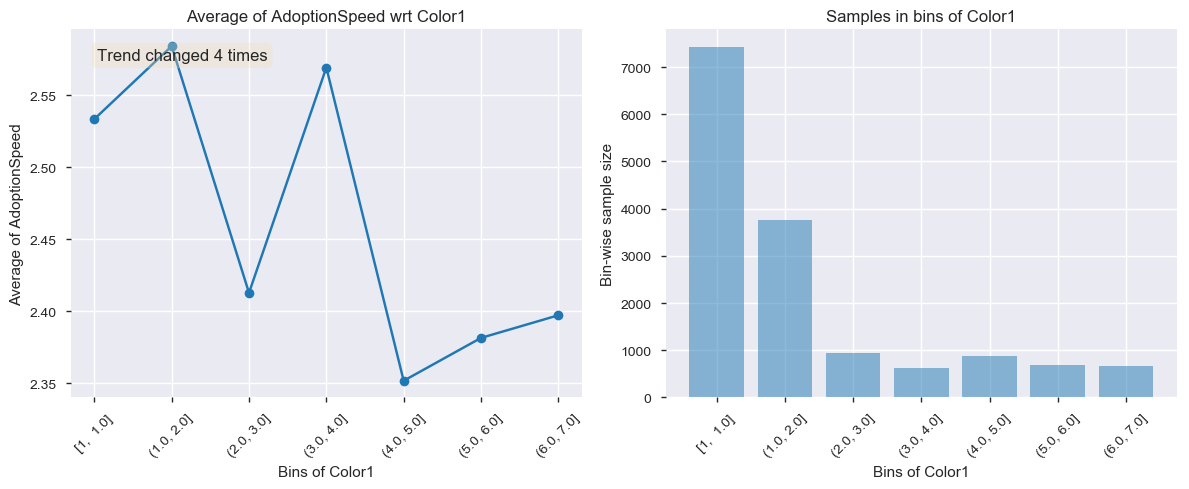

--------------------------------------------------------------------------------------------------------------


                                           Plots for Color2                                           


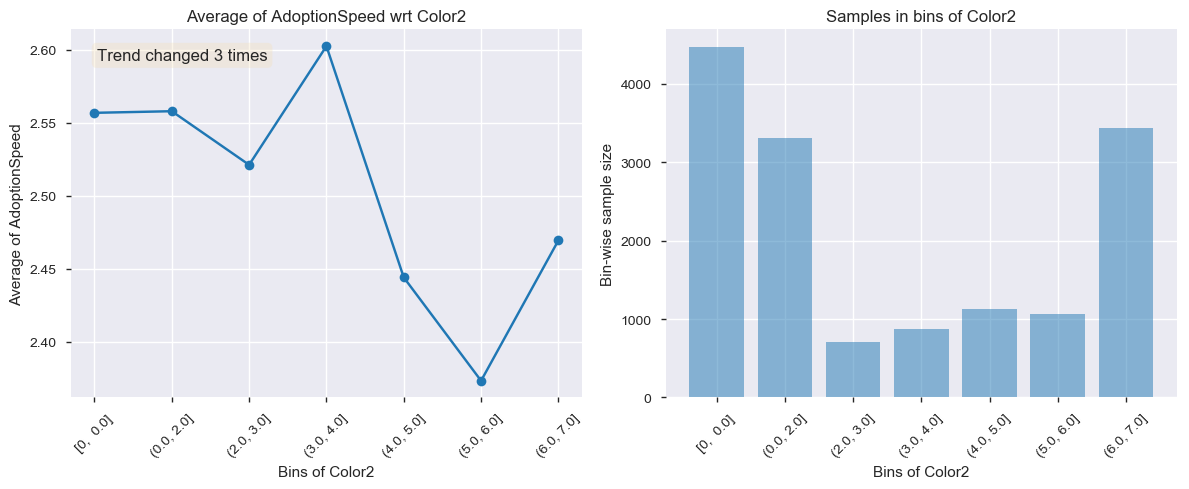

--------------------------------------------------------------------------------------------------------------


                                           Plots for Color3                                           


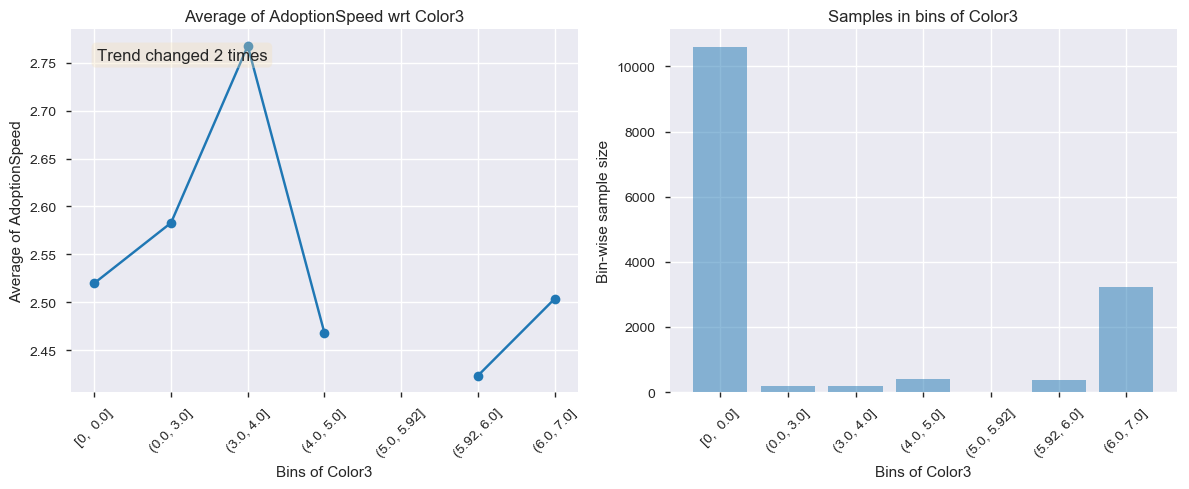

--------------------------------------------------------------------------------------------------------------


                                        Plots for MaturitySize                                        


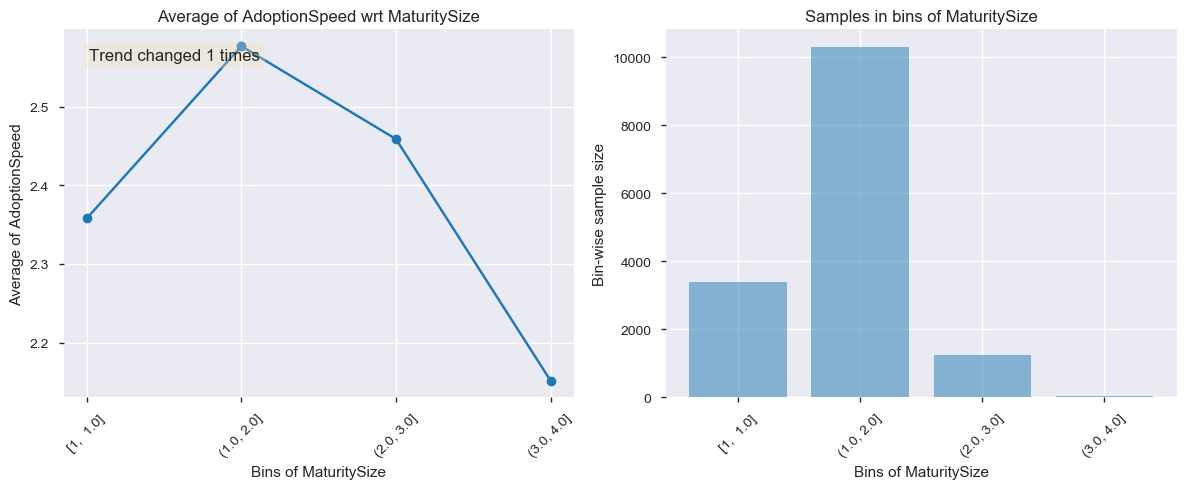

--------------------------------------------------------------------------------------------------------------


                                         Plots for FurLength                                          


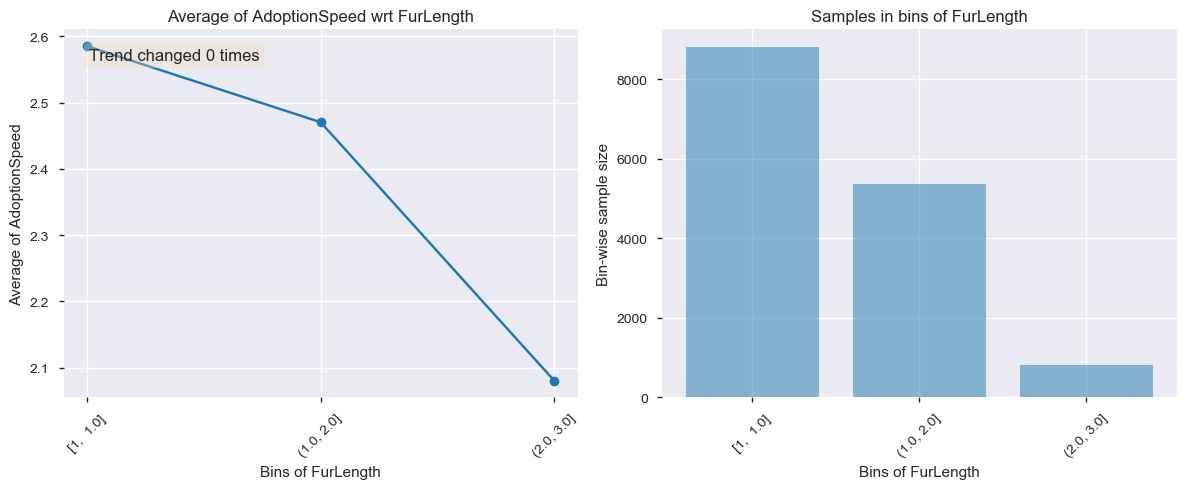

--------------------------------------------------------------------------------------------------------------


                                         Plots for Vaccinated                                         


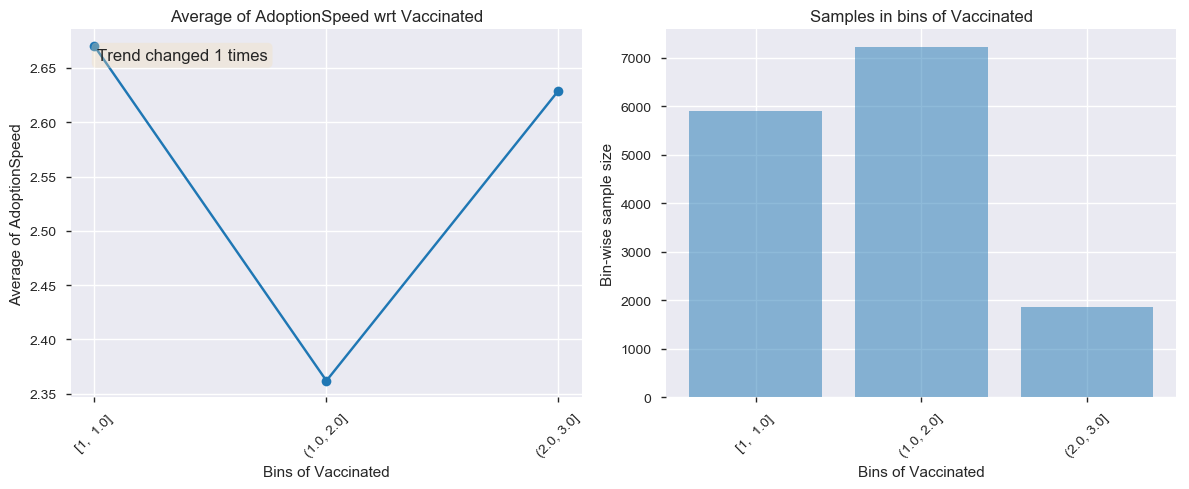

--------------------------------------------------------------------------------------------------------------


                                          Plots for Dewormed                                          


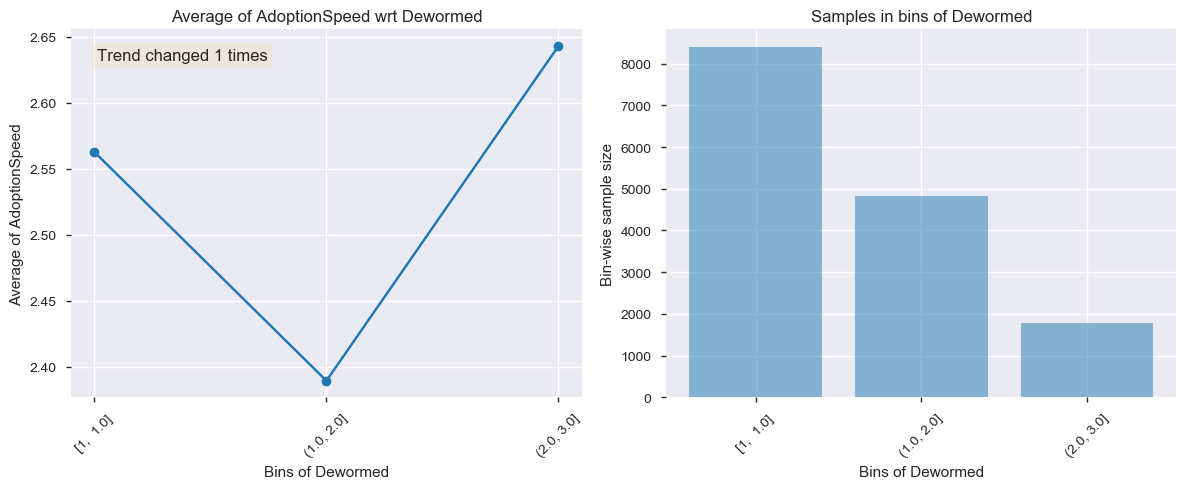

--------------------------------------------------------------------------------------------------------------


                                         Plots for Sterilized                                         


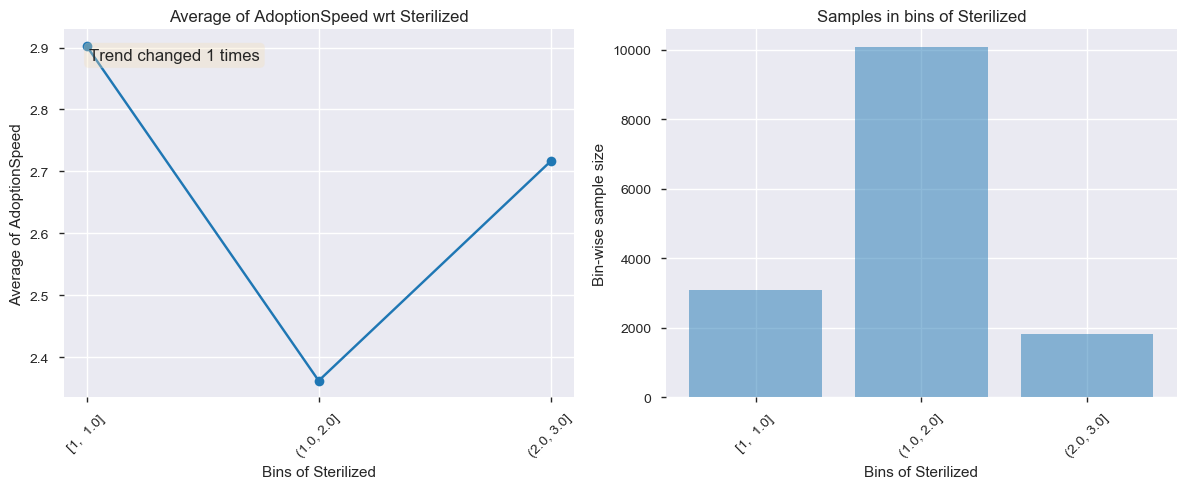

--------------------------------------------------------------------------------------------------------------


                                           Plots for Health                                           


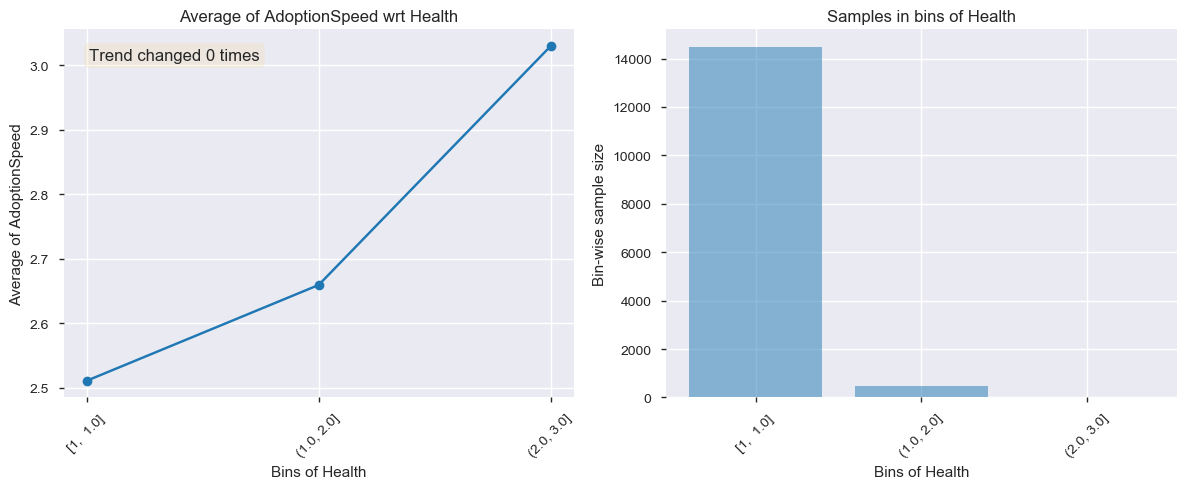

--------------------------------------------------------------------------------------------------------------


                                          Plots for Quantity                                          


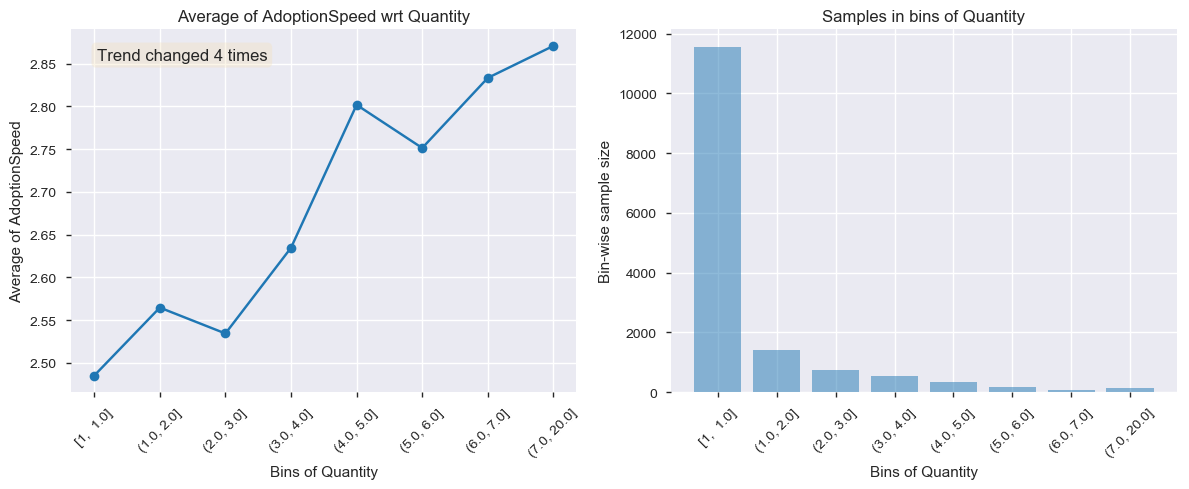

--------------------------------------------------------------------------------------------------------------


                                            Plots for Fee                                             


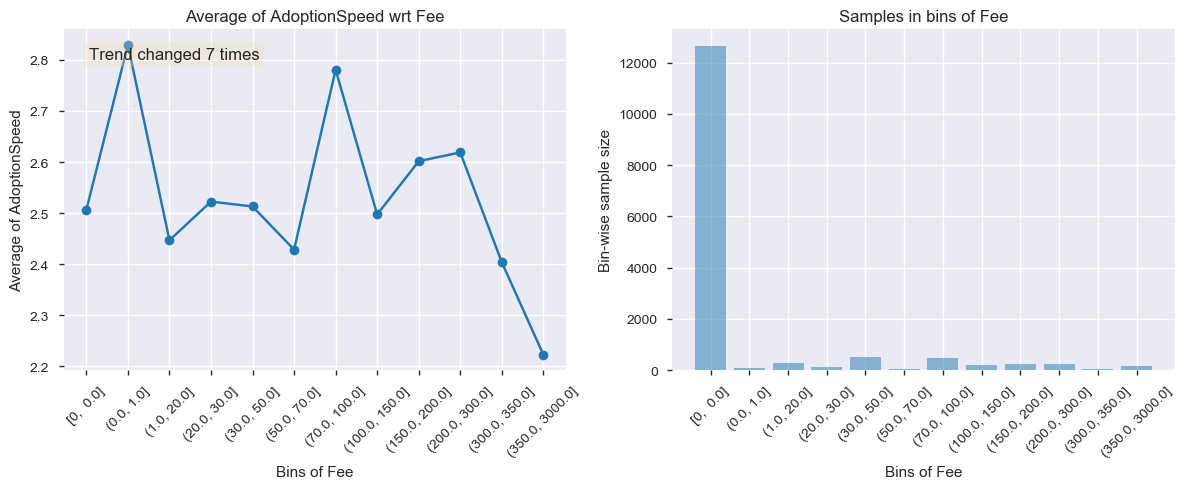

--------------------------------------------------------------------------------------------------------------


                                           Plots for State                                            


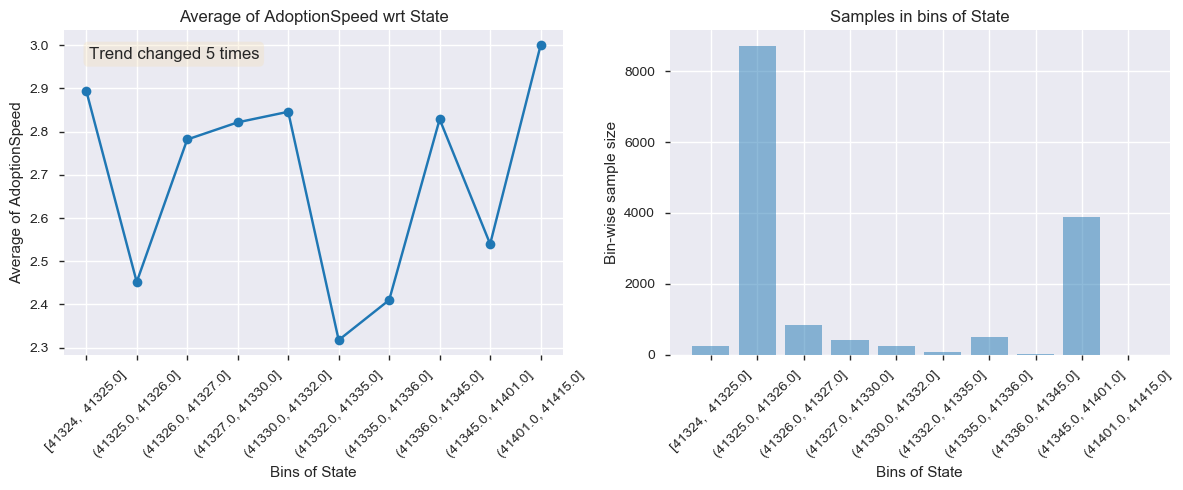

--------------------------------------------------------------------------------------------------------------




In [22]:
# Plots drawn for all features looking at trends and binning of the trends
get_univariate_plots(data=data_r, target_col='AdoptionSpeed', 
                     features_list=['Type', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State'], bins=100)

In [23]:
# looking for missing and unique values from the raw data 
data_r_stats = pd.DataFrame(columns = ['column', 'values', 'values_count_incna', 'values_count_nona', 
                                       'num_miss', 'pct_miss'])
tmp = pd.DataFrame()

for c in data_r.columns:
    tmp['column'] = [c]
    tmp['values'] = [data_r[c].unique()]
    tmp['values_count_incna'] = len(list(data_r[c].unique()))
    tmp['values_count_nona'] = int(data_r[c].nunique())
    tmp['num_miss'] = data_r[c].isnull().sum()
    tmp['pct_miss'] = (data_r[c].isnull().sum()/ len(data_r)).round(3)*100
    data_r_stats = data_r_stats.append(tmp)

In [24]:
# Ascending sort on the Number of Distinct Categories for each categorical Variables
data_r_stats.sort_values(by = 'values_count_incna', inplace = True, ascending = True)

# Setting the index to Column Names
data_r_stats.set_index('column', inplace = True)
data_r_stats 

values  \
column                                                             
Type                                                      [2, 1]   
Health                                                 [1, 2, 3]   
Sterilized                                             [2, 3, 1]   
Dewormed                                               [2, 3, 1]   
FurLength                                              [1, 2, 3]   
Vaccinated                                             [2, 3, 1]   
Gender                                                 [1, 2, 3]   
MaturitySize                                        [1, 2, 3, 4]   
AdoptionSpeed                                    [2, 0, 3, 1, 4]   
Color3                                        [0, 7, 5, 6, 4, 3]   
Color1                                     [1, 2, 5, 6, 3, 7, 4]   
Color2                                     [7, 2, 0, 6, 5, 4, 3]   
VideoAmt                             [0, 1, 3, 4, 2, 6, 5, 7, 8]   
State          [41326, 41401, 41330, 41327, 41361, 41336, 413...   
Quantity       [1, 6, 7, 5, 3, 10, 2, 9, 4, 8, 20, 18, 12, 11...   
PhotoAmt       [1.0, 2.0, 7.0, 8.0, 3.0, 9.0, 6.0, 5.0, 0.0, ...   
Fee            [100, 0, 150, 300, 50, 10, 1, 30, 750, 400, 80...   
Age            [3, 1, 4, 12, 0, 2, 78, 6, 8, 10, 36, 14, 24, ...   
Breed2         [0, 264, 205, 307, 117, 251, 265, 218, 292, 26...   
Breed1         [299, 265, 307, 266, 264, 218, 114, 285, 189, ...   
RescuerID      [8480853f516546f6cf33aa88cd76c379, 3082c7125d8...   
Name           [Nibble, No Name Yet, Brisco, Miko, Hunter, na...   
Description    [Nibble is a 3+ month old ball of cuteness. He...   
PetID          [86e1089a3, 6296e909a, 3422e4906, 5842f1ff5, 8...   

              values_count_incna values_count_nona num_miss  pct_miss  
column                                                                 
Type                           2                 2        0       0.0  
Health                         3                 3        0       0.0  
Sterilized                     3                 3        0       0.0  
Dewormed                       3                 3        0       0.0  
FurLength                      3                 3        0       0.0  
Vaccinated                     3                 3        0       0.0  
Gender                         3                 3        0       0.0  
MaturitySize                   4                 4        0       0.0  
AdoptionSpeed                  5                 5        0       0.0  
Color3                         6                 6        0       0.0  
Color1                         7                 7        0       0.0  
Color2                         7                 7        0       0.0  
VideoAmt                       9                 9        0       0.0  
State                         14                14        0       0.0  
Quantity                      19                19        0       0.0  
PhotoAmt                      31                31        0       0.0  
Fee                           74                74        0       0.0  
Age                          106               106        0       0.0  
Breed2                       135               135        0       0.0  
Breed1                       176               176        0       0.0  
RescuerID                   5595              5595        0       0.0  
Name                        9061              9060     1257       8.4  
Description                14033             14032       12       0.1  
PetID                      14993             14993        0       0.0

In [25]:
# Total number of missing values for each feature
print(data_r.isnull().sum())

Type                0
Name             1257
Age                 0
Breed1              0
Breed2              0
Gender              0
Color1              0
Color2              0
Color3              0
MaturitySize        0
FurLength           0
Vaccinated          0
Dewormed            0
Sterilized          0
Health              0
Quantity            0
Fee                 0
State               0
RescuerID           0
VideoAmt            0
Description        12
PetID               0
PhotoAmt            0
AdoptionSpeed       0
dtype: int64


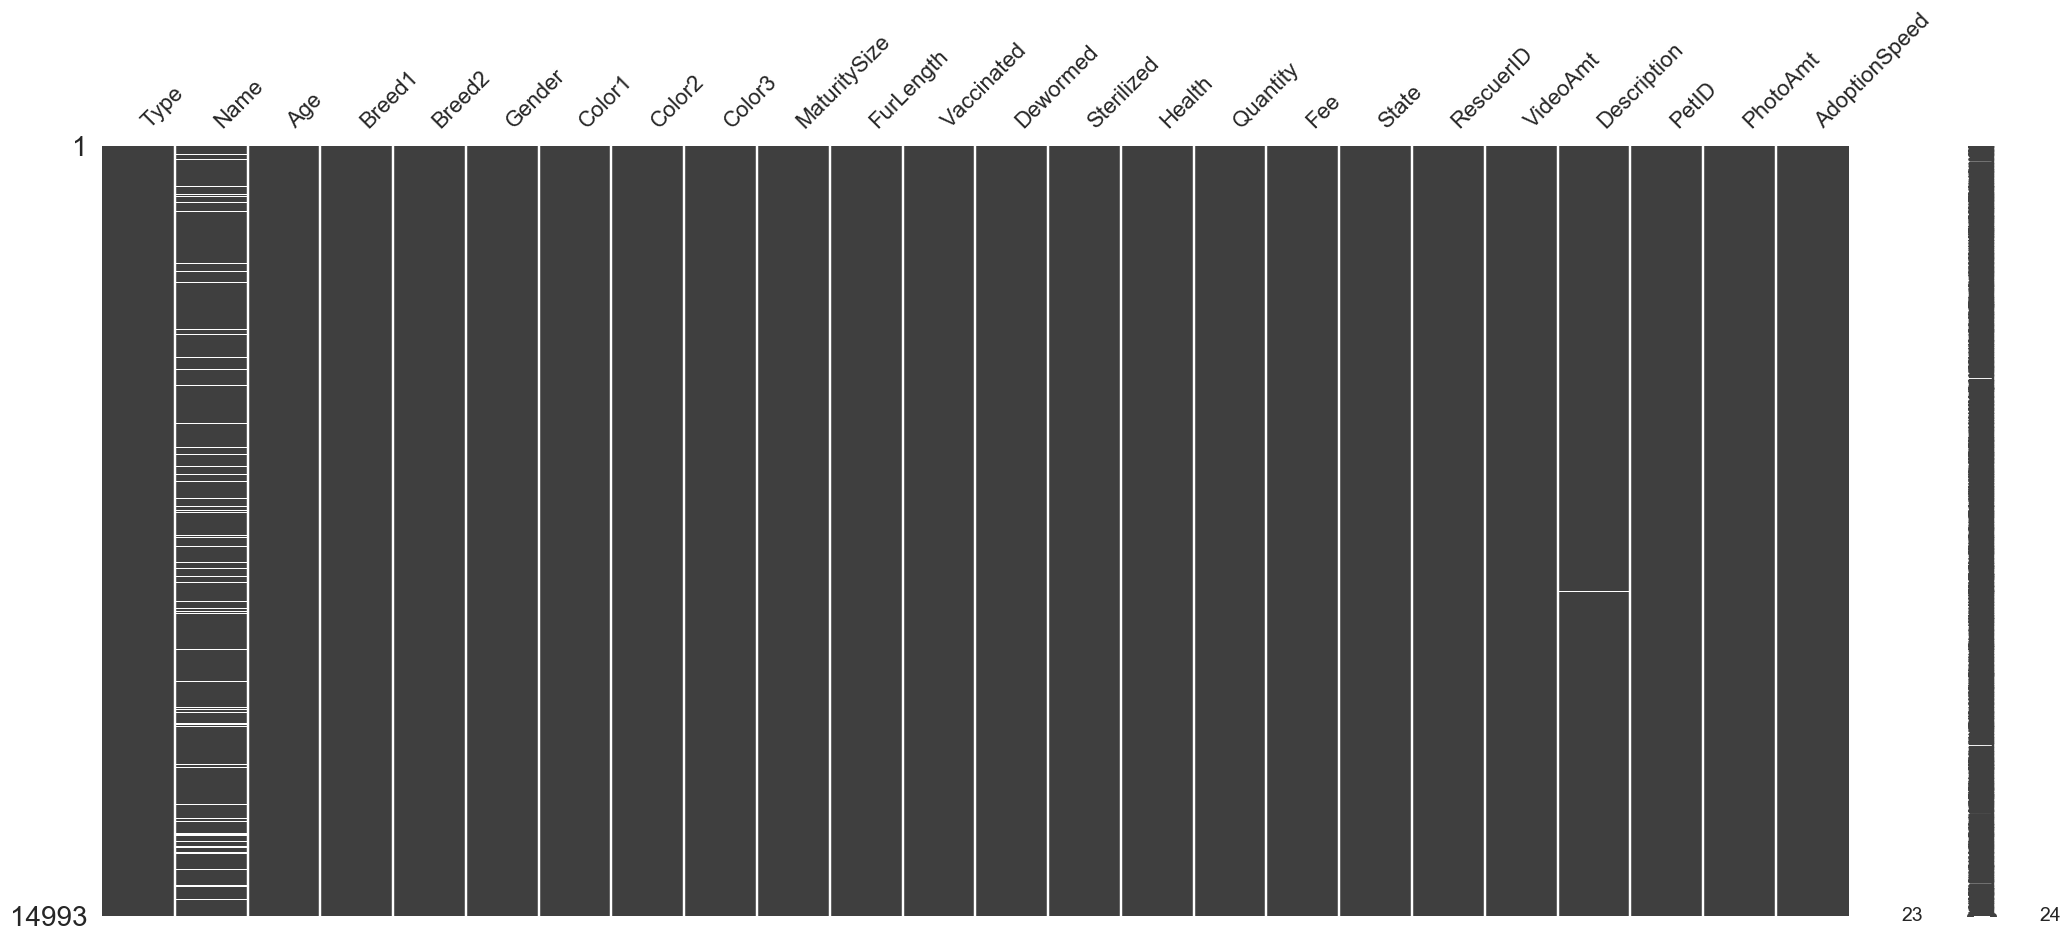

In [26]:
## Missing Value Matrix displaying the distribution of the missing values
msno.matrix(data_r)

In [27]:
## Dropping the non-numerical data from the raw data set
data_r2 = data_r.drop(['Name','Description','PetID','PhotoAmt','VideoAmt','RescuerID'],  axis=1)
data_r2.columns

Index(['Type', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'AdoptionSpeed'],
      dtype='object')

In [28]:
############# Univariate Analysis 

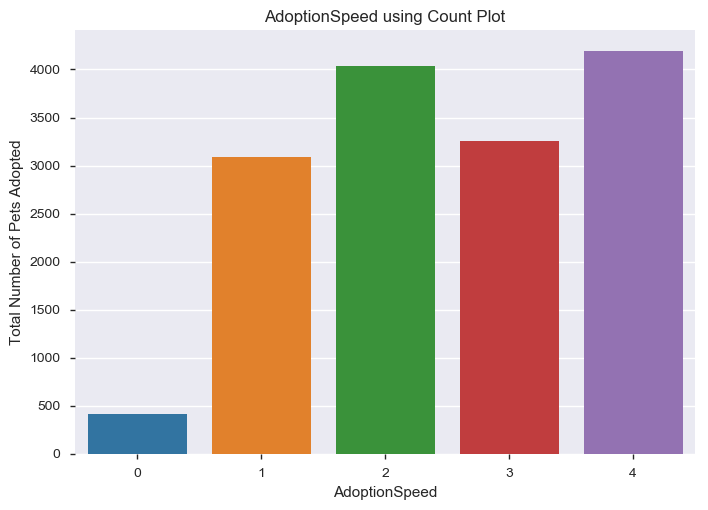

In [29]:
## Bar and Count Plots 
count, ax = plt.subplots()
ax = sns.countplot('AdoptionSpeed', data=data_r2)
ax.set_title('AdoptionSpeed using Count Plot')
ax.set_xlabel('AdoptionSpeed')
ax.set_ylabel('Total Number of Pets Adopted')

plt.show()

In [30]:
## Creating a Bar Chart and Inferential Statistics for individual attributes
def categorical_summarized(dataframe, x=None, y=None, hue=None, palette='Set1', verbose=True):
    if x == None:
        column_interested = y
    else:
        column_interested = x
    series = dataframe[column_interested]
    print(series.describe())
    print('mode: ', series.mode())
    if verbose:
        print('='*80)
        print(series.value_counts())

    sns.countplot(x=x, y=y, hue=hue, data=dataframe, palette=palette)
    plt.show()

count    14993.000000
mean         2.516441
std          1.177265
min          0.000000
25%          2.000000
50%          2.000000
75%          4.000000
max          4.000000
Name: AdoptionSpeed, dtype: float64
mode:  0    4
dtype: int64
4    4197
2    4037
3    3259
1    3090
0     410
Name: AdoptionSpeed, dtype: int64


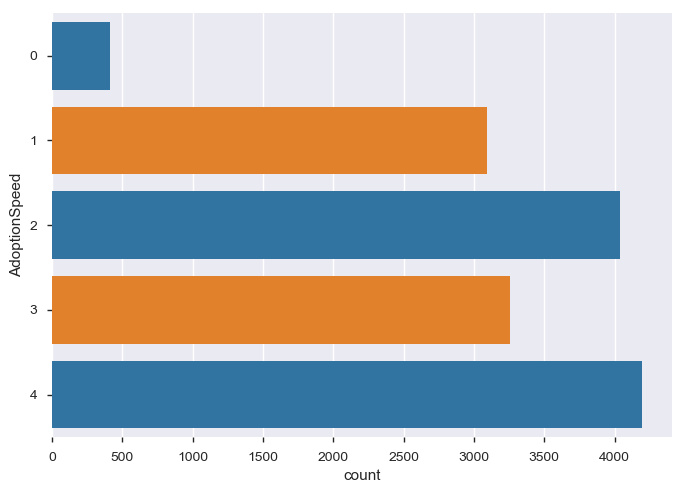

In [31]:
# Bar Chart for the Target Variable
c_palette = ['tab:blue', 'tab:orange']
categorical_summarized(data_r2, y = 'AdoptionSpeed', palette=c_palette)
plt.show()

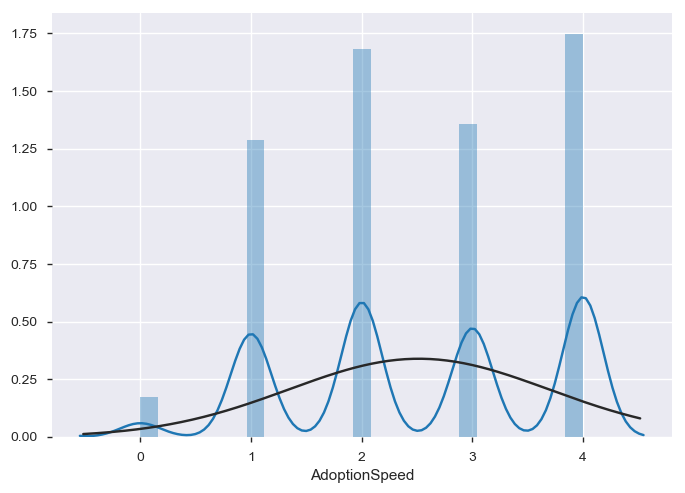

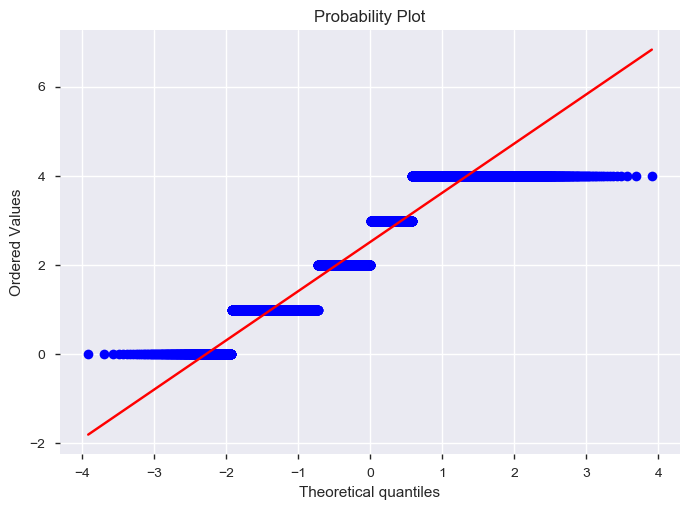

In [32]:
#histogram and normal probability plot
sns.distplot(data_r2['AdoptionSpeed'], fit=norm);
fig = plt.figure()
res = stats.probplot(data_r['AdoptionSpeed'], plot=plt)

In [33]:
# Creating another column for the new binned AdoptionSeed variable
data_r2["AdoptionSpeed_t"]=data_r2["AdoptionSpeed"]
data_r.head(1)

Type    Name  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  \
0     2  Nibble    3     299       0       1       1       7       0   

   MaturitySize      ...        Health  Quantity  Fee  State  \
0             1      ...             1         1  100  41326   

                          RescuerID  VideoAmt  \
0  8480853f516546f6cf33aa88cd76c379         0   

                                         Description      PetID PhotoAmt  \
0  Nibble is a 3+ month old ball of cuteness. He ...  86e1089a3      1.0   

   AdoptionSpeed  
0              2  

[1 rows x 24 columns]

In [34]:
## Binnng the AdoptionSpeed Category into a binary data set
data_r2.AdoptionSpeed_t[data_r2.AdoptionSpeed == 0] = 0
data_r2.AdoptionSpeed_t[data_r2.AdoptionSpeed == 1] = 0
data_r2.AdoptionSpeed_t[data_r2.AdoptionSpeed == 2] = 0
data_r2.AdoptionSpeed_t[data_r2.AdoptionSpeed == 3] = 1
data_r2.AdoptionSpeed_t[data_r2.AdoptionSpeed == 4] = 1

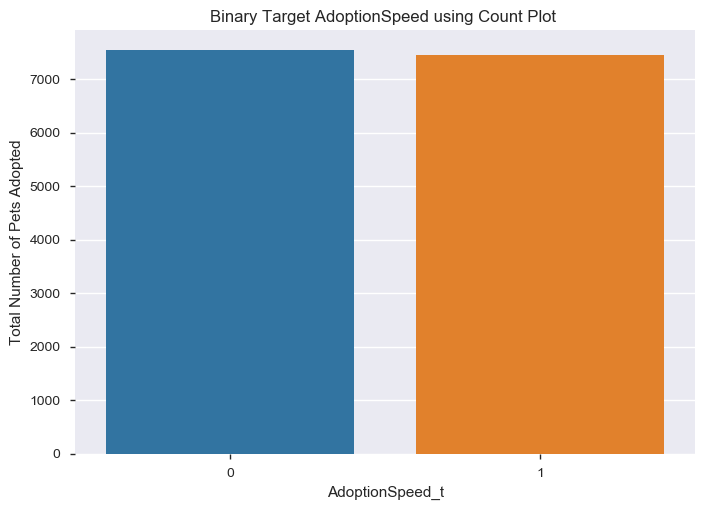

In [35]:
# Printing the Bar and Count Plot for the new Binned AdoptionSPeed_t variable. 
count, ax = plt.subplots()
ax = sns.countplot('AdoptionSpeed_t', data=data_r2)
ax.set_title('Binary Target AdoptionSpeed using Count Plot ')
ax.set_xlabel('AdoptionSpeed_t')
ax.set_ylabel('Total Number of Pets Adopted')

plt.show()

In [36]:
# Creating another column for another binned Target Variable
data_r2["AdoptionSpeed_t2"]=data_r2["AdoptionSpeed"]
data_r2.head(1)

Type  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  MaturitySize  \
0     2    3     299       0       1       1       7       0             1   

   FurLength  Vaccinated  Dewormed  Sterilized  Health  Quantity  Fee  State  \
0          1           2         2           2       1         1  100  41326   

   AdoptionSpeed  AdoptionSpeed_t  AdoptionSpeed_t2  
0              2                0                 2

In [37]:
## Binnng the Target Variable into a new Binary Categorical Variable
data_r2.AdoptionSpeed_t2[data_r2.AdoptionSpeed == 0] = 0
data_r2.AdoptionSpeed_t2[data_r2.AdoptionSpeed == 1] = 0
data_r2.AdoptionSpeed_t2[data_r2.AdoptionSpeed == 2] = 0
data_r2.AdoptionSpeed_t2[data_r2.AdoptionSpeed == 3] = 0
data_r2.AdoptionSpeed_t2[data_r2.AdoptionSpeed == 4] = 1

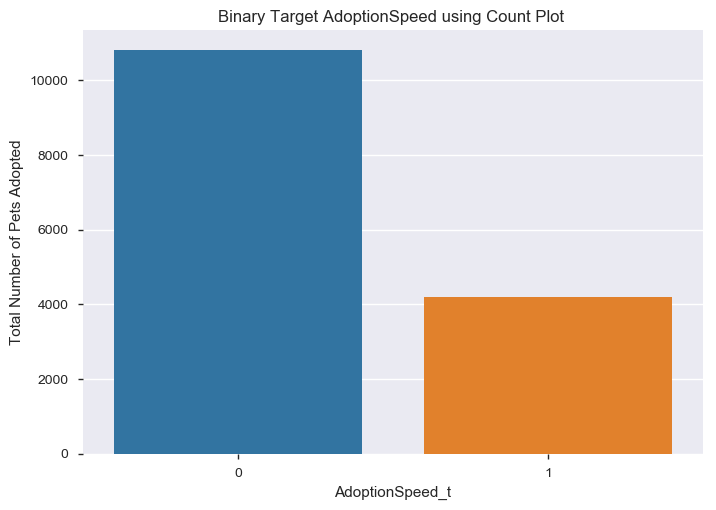

In [38]:
# Bar and Count Plot for the new binned Target Variable. 
count, ax = plt.subplots()
ax = sns.countplot('AdoptionSpeed_t2', data=data_r2)
ax.set_title('Binary Target AdoptionSpeed using Count Plot ')
ax.set_xlabel('AdoptionSpeed_t')
ax.set_ylabel('Total Number of Pets Adopted')

plt.show()

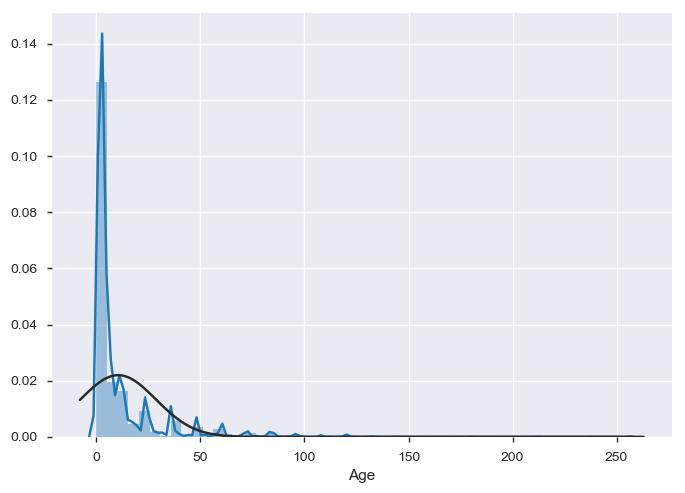

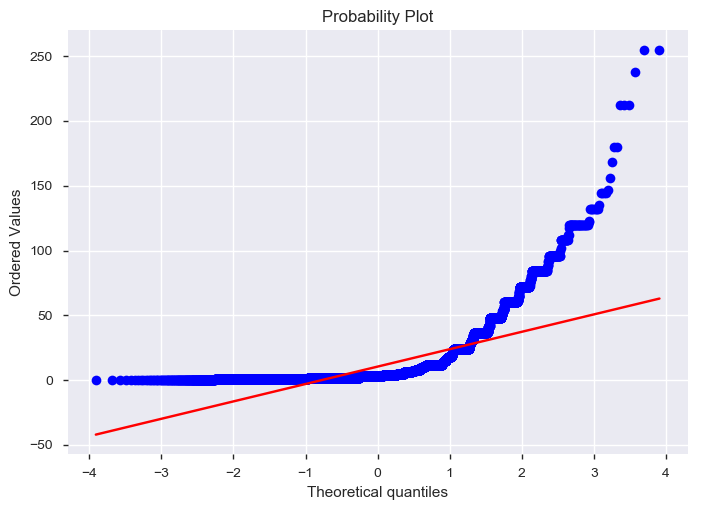

In [39]:
#histogram and normal probability plot 
sns.distplot(data_r2['Age'], fit=norm);
fig = plt.figure()
res = stats.probplot(data_r['Age'], plot=plt)

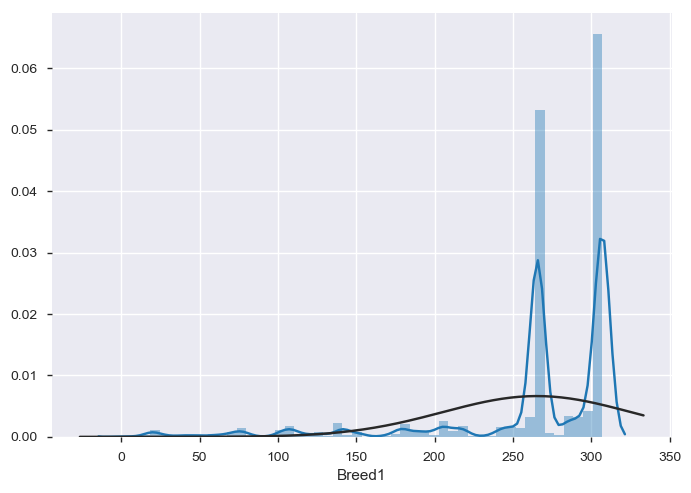

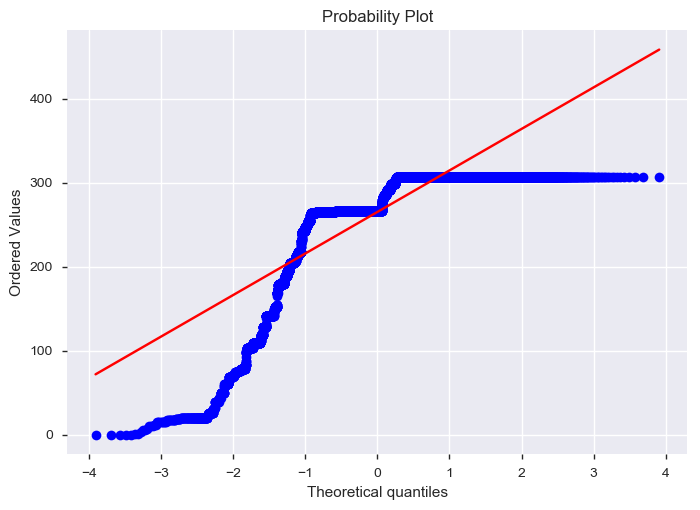

In [40]:
#histogram and normal probability plot 
sns.distplot(data_r['Breed1'], fit=norm);
fig = plt.figure()
res = stats.probplot(data_r['Breed1'], plot=plt)

#histogram and normal probability plot 
sns.distplot(data_r.iloc[:,2], fit=norm);
fig = plt.figure()
res = stats.probplot(data_r.iloc[:,2], plot=plt)

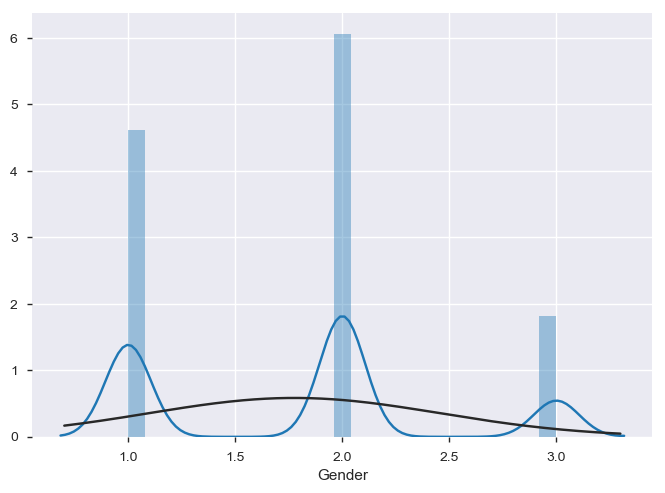

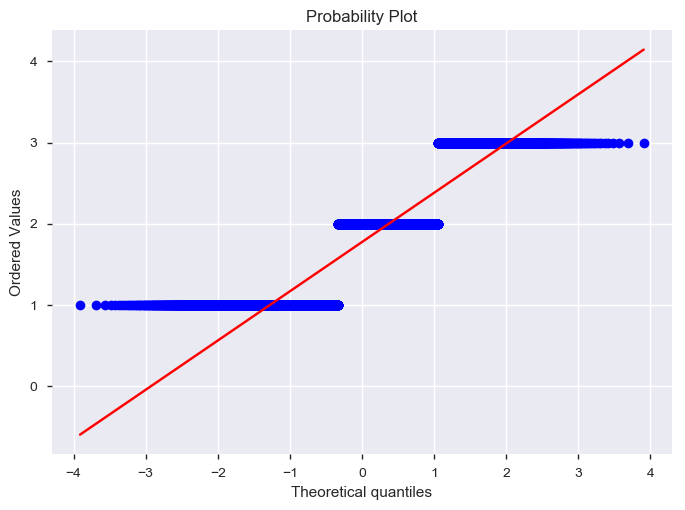

In [41]:
#histogram and normal probability plot
sns.distplot(data_r2['Gender'], fit=norm);
fig = plt.figure()
res = stats.probplot(data_r['Gender'], plot=plt)

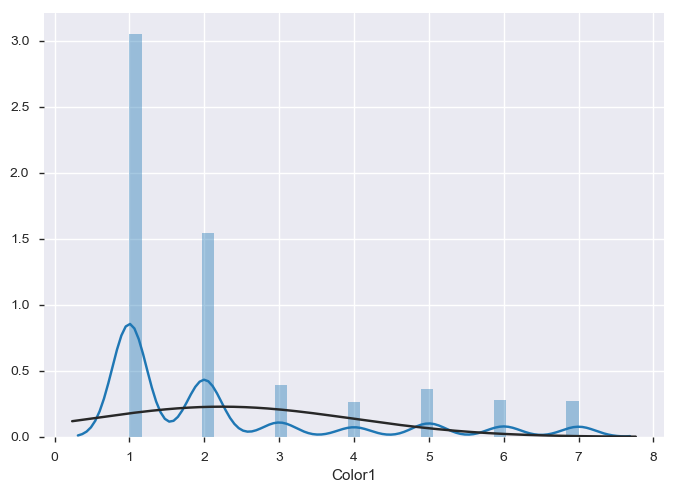

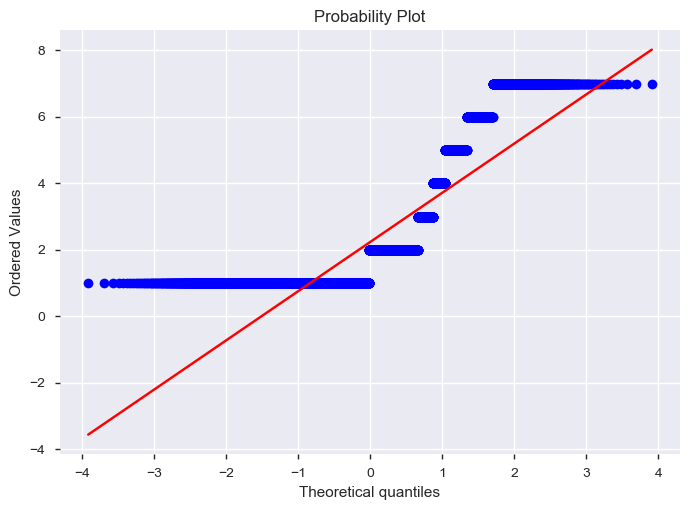

In [42]:
#histogram and normal probability plot
sns.distplot(data_r['Color1'], fit=norm);
fig = plt.figure()
res = stats.probplot(data_r['Color1'], plot=plt)

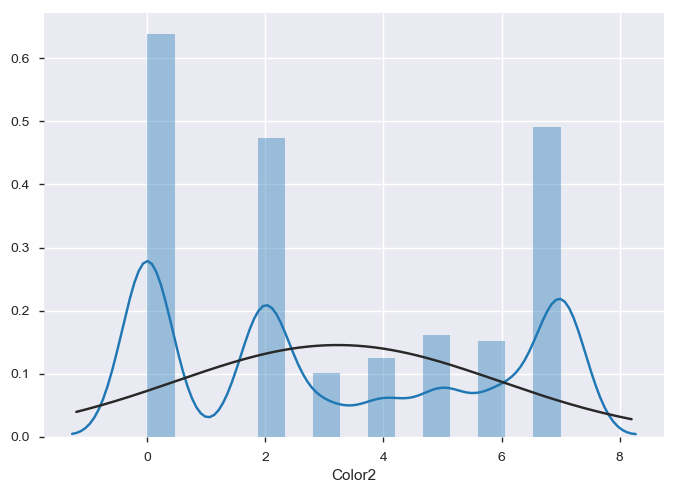

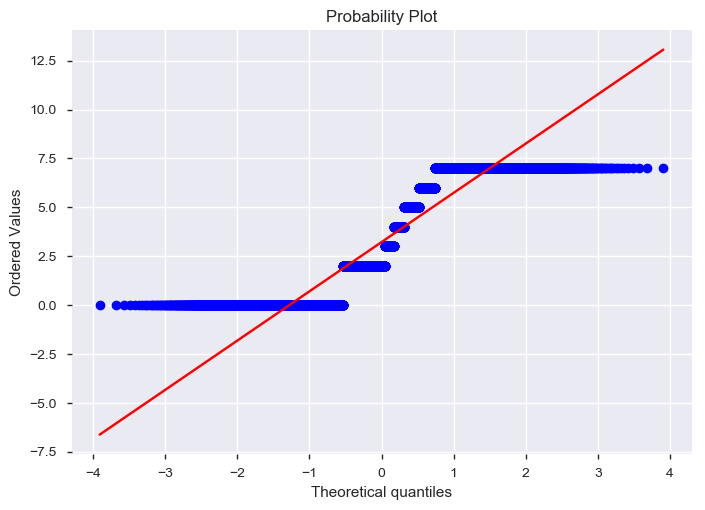

In [43]:
#histogram and normal probability plot
sns.distplot(data_r2['Color2'], fit=norm);
fig = plt.figure()
res = stats.probplot(data_r2['Color2'], plot=plt)

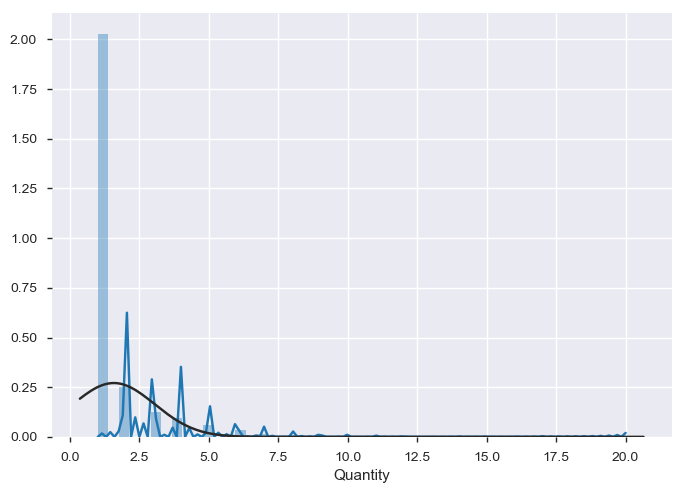

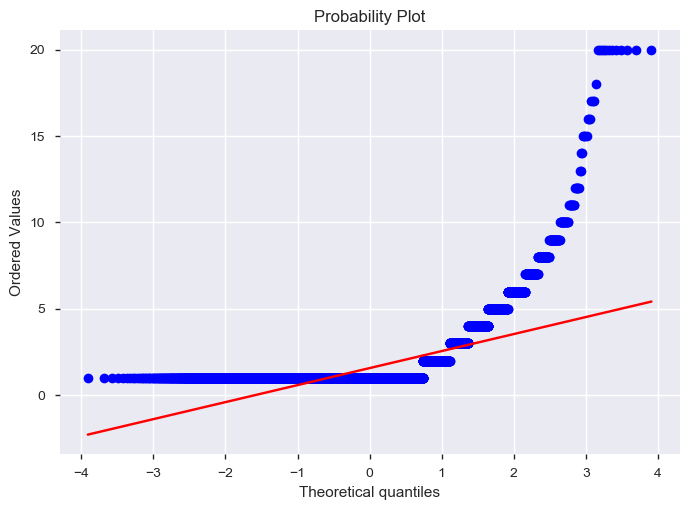

In [44]:
#histogram and normal probability plot
sns.distplot(data_r['Quantity'], fit=norm);
fig = plt.figure()
res = stats.probplot(data_r['Quantity'], plot=plt)

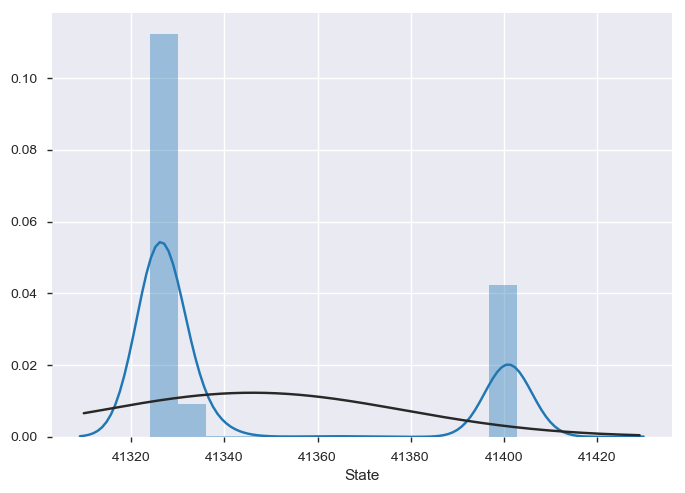

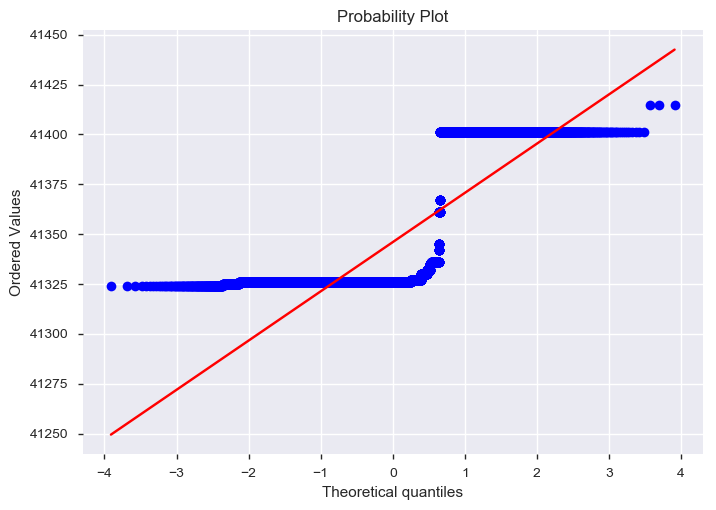

In [45]:
#histogram and normal probability plot
sns.distplot(data_r2['State'], fit=norm);
fig = plt.figure()
res = stats.probplot(data_r2['State'], plot=plt)

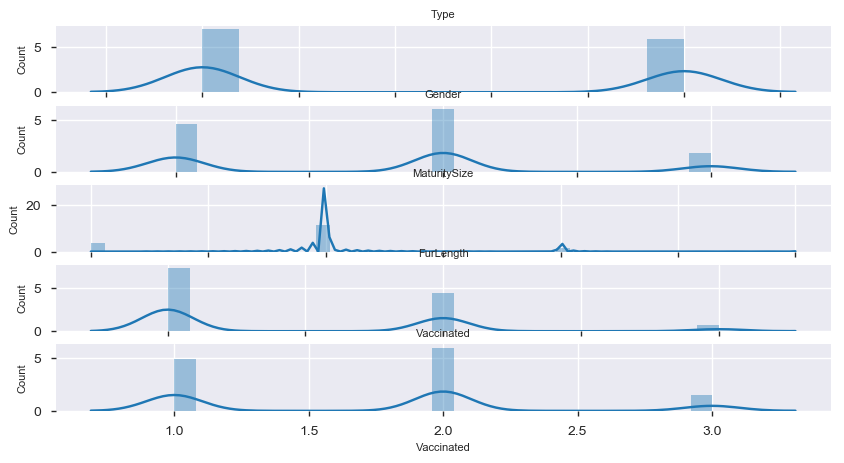

In [46]:
# Bar and count plot for the remaining attributes
col_names = ['Type','Gender', 'MaturitySize', 'FurLength', 'Vaccinated']

fig, ax = plt.subplots(len(col_names), figsize=(10,5))

for i, col_val in enumerate(col_names):

    sns.distplot(data_r[col_val], hist=True, ax=ax[i])
    ax[i].set_title(col_val, fontsize=8)
    ax[i].set_xlabel(col_val, fontsize=8)
    ax[i].set_ylabel('Count', fontsize=8)

plt.show()

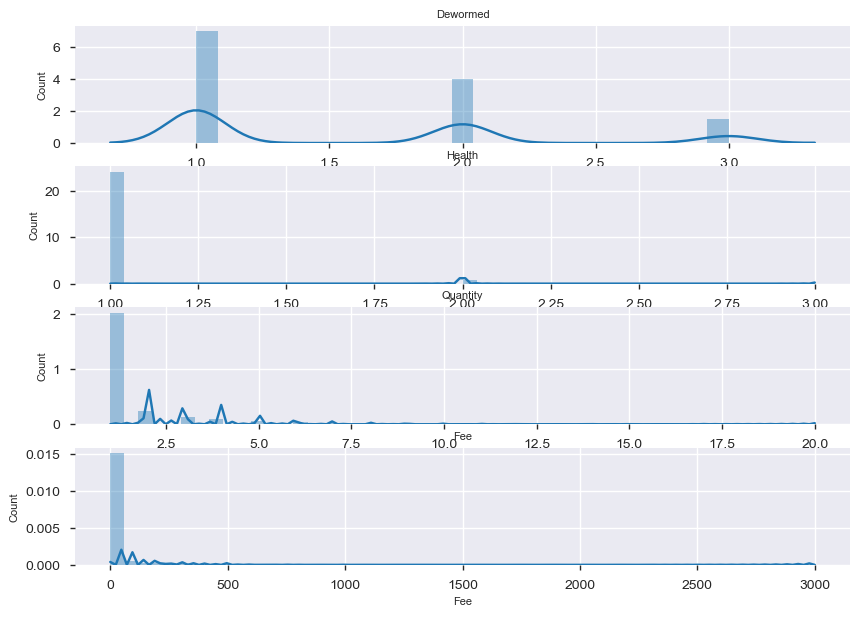

In [47]:
# Bar and count plot for the remaining attributes
col_names = ['Dewormed', 'Health', 'Quantity', 'Fee']

fig, ax = plt.subplots(len(col_names), figsize=(10,7))

for i, col_val in enumerate(col_names):

    sns.distplot(data_r[col_val], hist=True, ax=ax[i])
    ax[i].set_title(col_val, fontsize=8)
    ax[i].set_xlabel(col_val, fontsize=8)
    ax[i].set_ylabel('Count', fontsize=8)

plt.show()

In [48]:
###### Bivariate Graph Analysis with Barcharts and PieCharts

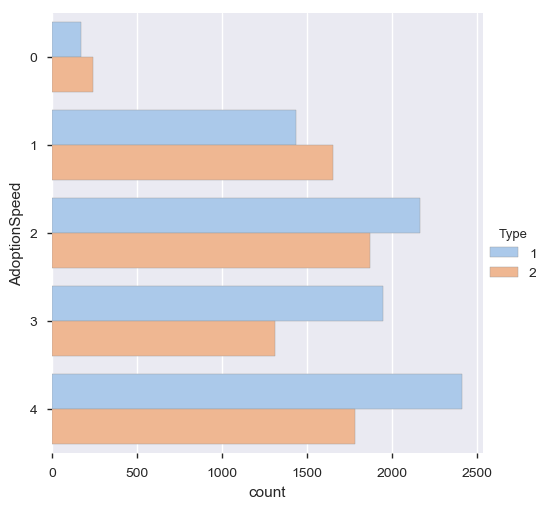

In [49]:
## Horizontal Histogram in Seaborn
sns.catplot(y="AdoptionSpeed", 
            hue="Type", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=data_r2);

In [50]:
# Cross Tabulation for Categorical Variables 
pd.crosstab(data_r2.AdoptionSpeed, data_r2.Type, margins=True)

Type              1     2    All
AdoptionSpeed                   
0               170   240    410
1              1435  1655   3090
2              2164  1873   4037
3              1949  1310   3259
4              2414  1783   4197
All            8132  6861  14993

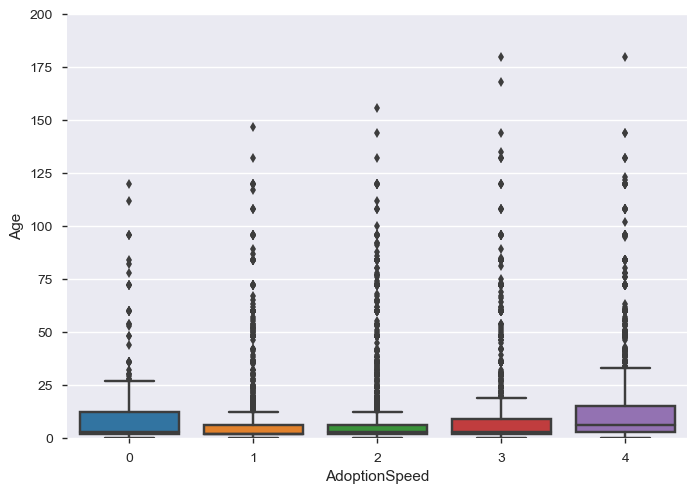

In [51]:
# Box and Whisker Plot for age and Target
fig = sns.boxplot(x='AdoptionSpeed', y="Age", data=data_r2)
fig.axis(ymin=0, ymax=200);

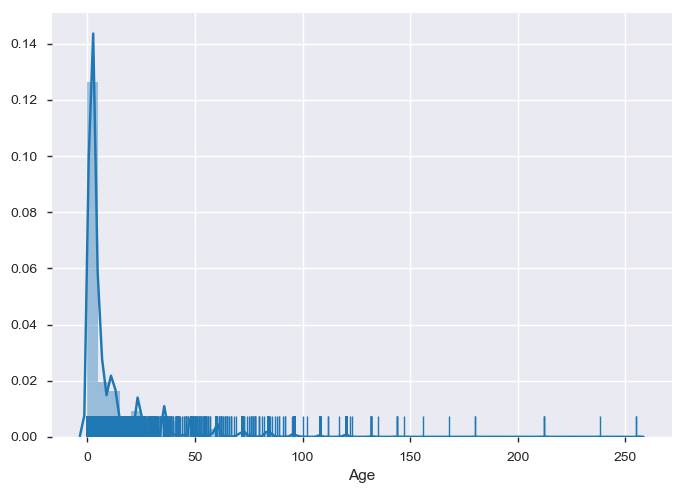

In [52]:
# Histogram + Rug + kernel density
sns.distplot( a=data_r2["Age"], hist=True, kde=True, rug=True )
plt.show()

In [53]:
# Creating a new column for the log10 tranformed Age Variable
data_r2["Age_t"]=data_r2["Age"]
data_r2.head(1)

Type  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  MaturitySize  \
0     2    3     299       0       1       1       7       0             1   

   FurLength  ...    Dewormed  Sterilized  Health  Quantity  Fee  State  \
0          1  ...           2           2       1         1  100  41326   

   AdoptionSpeed  AdoptionSpeed_t  AdoptionSpeed_t2  Age_t  
0              2                0                 0      3  

[1 rows x 21 columns]

In [54]:
## Log10 Transformation for the Age 
data_r2.Age_t=np.log10(data_r2.Age_t)
data_r2.head(1)

Type  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  MaturitySize  \
0     2    3     299       0       1       1       7       0             1   

   FurLength    ...     Dewormed  Sterilized  Health  Quantity  Fee  State  \
0          1    ...            2           2       1         1  100  41326   

   AdoptionSpeed  AdoptionSpeed_t  AdoptionSpeed_t2     Age_t  
0              2                0                 0  0.477121  

[1 rows x 21 columns]

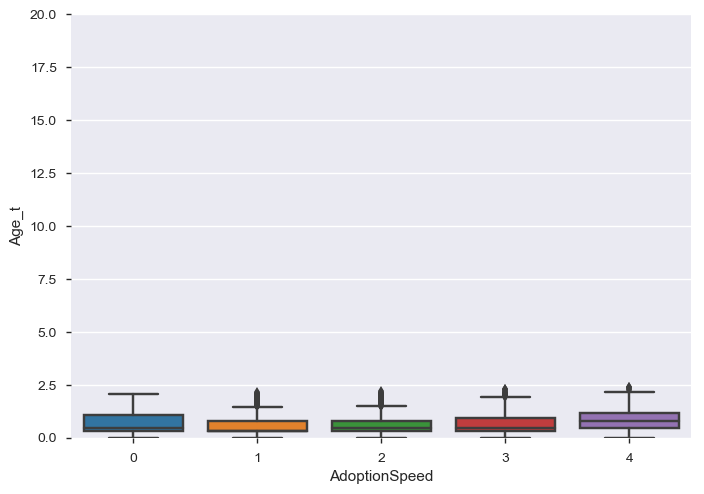

In [55]:
# Box and Whisker plot for the Age transformed variable
fig = sns.boxplot(x='AdoptionSpeed', y="Age_t", data=data_r2)
fig.axis(ymin=0, ymax=20);

In [56]:
# Cross Tabulation for Categorical Variables 
pd.crosstab(data_r2.AdoptionSpeed, data_r2.Age, margins=True)

Age              0     1     2     3     4    5    6    7    8    9  ...    \
AdoptionSpeed                                                        ...     
0               10    54   115    44    24    7   20    7    4    5  ...     
1               50   643   865   408   211  100   80   43   36   24  ...     
2               44   754  1120   586   265  157  117   59   68   51  ...     
3               39   511   783   458   260  135  115   62   70   31  ...     
4               36   342   620   470   349  196  226  110  131   73  ...     
All            179  2304  3503  1966  1109  595  558  281  309  184  ...     

Age            135  144  147  156  168  180  212  238  255    All  
AdoptionSpeed                                                      
0                0    0    0    0    0    0    0    0    0    410  
1                0    0    1    0    0    0    0    0    0   3090  
2                0    1    0    1    0    0    0    0    0   4037  
3                1    1    0    0    1    1    2    0    0   3259  
4                0    2    0    0    0    1    1    1    2   4197  
All              1    4    1    1    1    2    3    1    2  14993  

[6 rows x 107 columns]

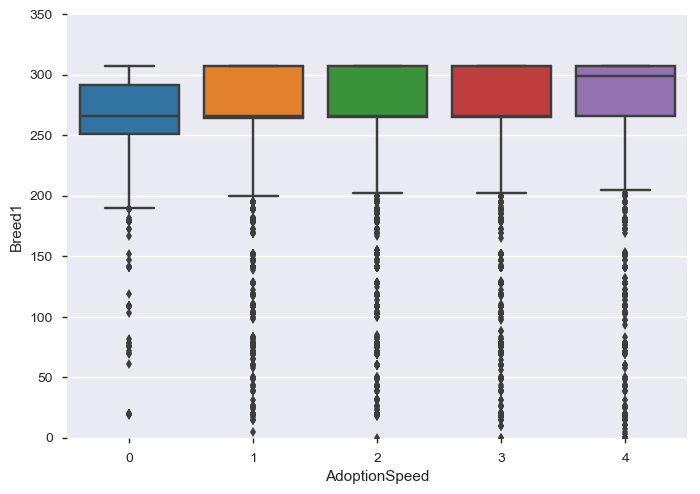

In [57]:
# Box and Whisker plot for the Breed1 variable
fig = sns.boxplot(x='AdoptionSpeed', y="Breed1", data=data_r2)
fig.axis(ymin=0, ymax=350);

In [58]:
# Creating a new column for the transformed Breed1_t variable
data_r2["Breed1_t"]=data_r2["Breed1"]
data_r2.head(1)

Type  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  MaturitySize  \
0     2    3     299       0       1       1       7       0             1   

   FurLength    ...     Sterilized  Health  Quantity  Fee  State  \
0          1    ...              2       1         1  100  41326   

   AdoptionSpeed  AdoptionSpeed_t  AdoptionSpeed_t2     Age_t  Breed1_t  
0              2                0                 0  0.477121       299  

[1 rows x 22 columns]

In [59]:
## Binnng uniqu values in Breed1 into a total of 4 unique bins 
data_r2.Breed1_t[data_r2.Breed1_t <= 260] = 260
data_r2.Breed1_t[data_r2.Breed1_t == 299] = 275
data_r2.Breed1_t[data_r2.Breed1_t == 266] = 275
data_r2.Breed1_t[data_r2.Breed1_t == 285] = 275
data_r2.Breed1_t[data_r2.Breed1_t == 292] = 275
data_r2.Breed1_t[data_r2.Breed1_t == 303] = 275
data_r2.Breed1_t[data_r2.Breed1_t == 283] = 275
data_r2.Breed1_t[data_r2.Breed1_t == 288] = 275
data_r2.Breed1_t[data_r2.Breed1_t == 284] = 275
data_r2.Breed1_t[data_r2.Breed1_t == 277] = 275
data_r2.Breed1_t[data_r2.Breed1_t == 296] = 275
data_r2.Breed1_t[data_r2.Breed1_t == 300] = 275
data_r2.Breed1_t[data_r2.Breed1_t == 294] = 275
data_r2.Breed1_t[data_r2.Breed1_t == 276] = 275
data_r2.Breed1_t[data_r2.Breed1_t == 289] = 275
data_r2.Breed1_t[data_r2.Breed1_t == 270] = 275
data_r2.Breed1_t[data_r2.Breed1_t == 267] = 275
data_r2.Breed1_t[data_r2.Breed1_t == 268] = 275
data_r2.Breed1_t[data_r2.Breed1_t == 295] = 275
data_r2.Breed1_t[data_r2.Breed1_t == 282] = 275
data_r2.Breed1_t[data_r2.Breed1_t == 272] = 275
data_r2.Breed1_t[data_r2.Breed1_t == 264] = 275
data_r2.Breed1_t[data_r2.Breed1_t == 286] = 275
data_r2.Breed1_t[data_r2.Breed1_t == 273] = 275
data_r2.Breed1_t[data_r2.Breed1_t == 293] = 275
data_r2.Breed1_t[data_r2.Breed1_t == 280] = 275
data_r2.Breed1_t[data_r2.Breed1_t == 274] = 275
data_r2.Breed1_t[data_r2.Breed1_t == 263] = 275
data_r2.Breed1_t[data_r2.Breed1_t == 290] = 275
data_r2.Breed1_t[data_r2.Breed1_t == 281] = 275
data_r2.Breed1_t[data_r2.Breed1_t == 279] = 275
data_r2.Breed1_t[data_r2.Breed1_t == 297] = 275
data_r2.Breed1_t[data_r2.Breed1_t == 269] = 275
data_r2.Breed1_t[data_r2.Breed1_t == 298] = 275
data_r2.Breed1_t[data_r2.Breed1_t == 271] = 275
data_r2.Breed1_t[data_r2.Breed1_t == 302] = 275
data_r2.Breed1_t[data_r2.Breed1_t == 305] = 275
data_r2.Breed1_t[data_r2.Breed1_t == 306] = 275
data_r2.Breed1_t[data_r2.Breed1_t == 304] = 275
data_r2.Breed1_t[data_r2.Breed1_t == 301] = 275
data_r2.Breed1_t[data_r2.Breed1_t == 262] = 265
data_r2.Breed1_t[data_r2.Breed1_t == 287] = 275

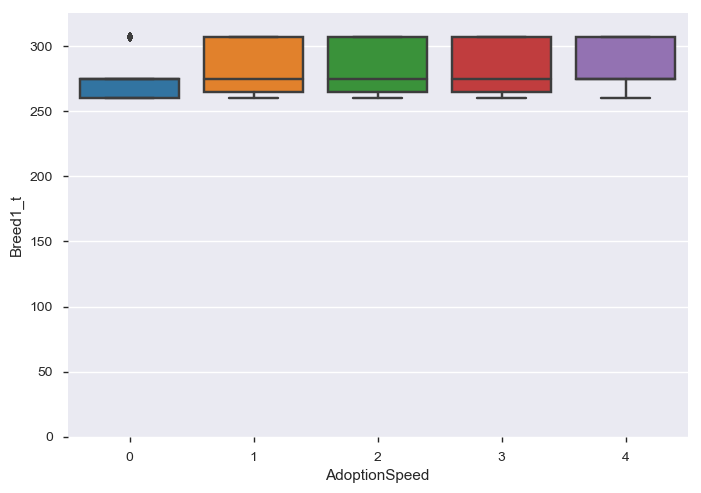

In [60]:
# Box and Whisker plot for the transformed Breeed1_t variable
fig = sns.boxplot(x='AdoptionSpeed', y="Breed1_t", data=data_r2)
fig.axis(ymin=0, ymax=325);

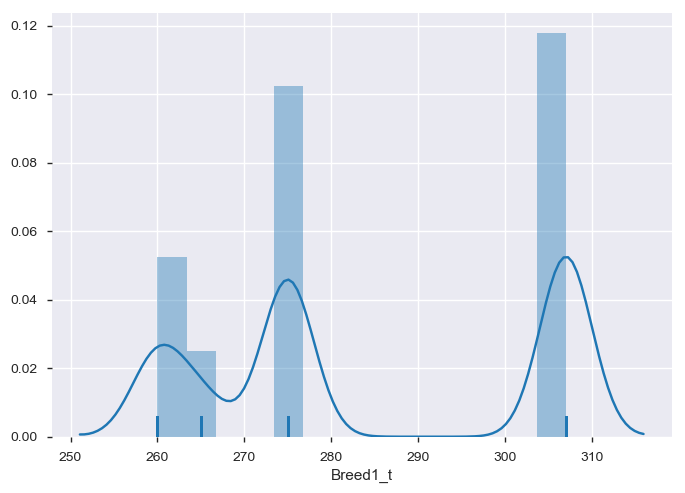

In [61]:
# Histogram + Rug + kernel density
sns.distplot( a=data_r2["Breed1_t"], hist=True, kde=True, rug=True )
plt.show()

In [62]:
## testing to make sure there are only four unique bins in the Breed1 category
data_r2.Breed1_t.unique()

array([275, 265, 307, 260], dtype=int64)

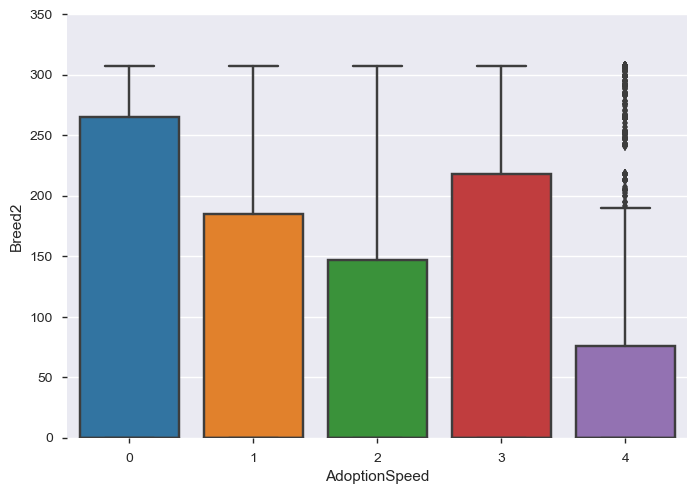

In [63]:
# Box and  Whisker Plot for Breed2
fig = sns.boxplot(x='AdoptionSpeed', y="Breed2", data=data_r2)
fig.axis(ymin=0, ymax=350);

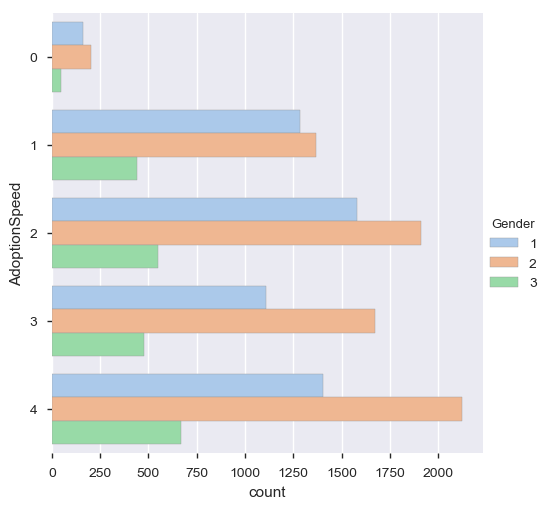

In [64]:
## Horizontal Bar Chart in Seaborn
sns.catplot(y="AdoptionSpeed", 
            hue="Gender", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=data_r2);

In [65]:
# Cross Tabulation for Categorical Variables 
pd.crosstab(data_r2.AdoptionSpeed, data_r2.Gender, margins=True)

Gender            1     2     3    All
AdoptionSpeed                         
0               160   204    46    410
1              1283  1366   441   3090
2              1578  1911   548   4037
3              1109  1671   479   3259
4              1406  2125   666   4197
All            5536  7277  2180  14993

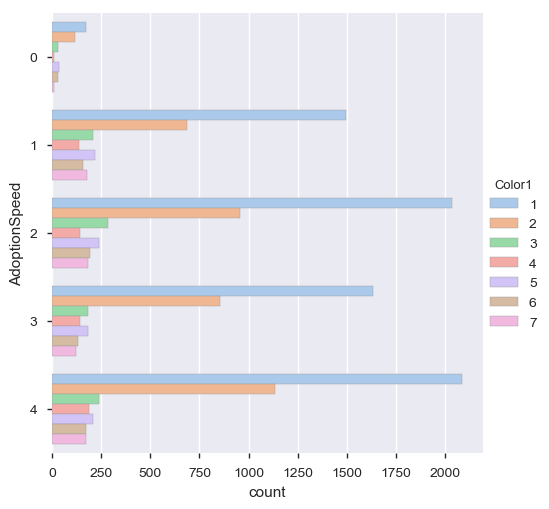

In [66]:
## Horizontal bar chart in Seaborn
sns.catplot(y="AdoptionSpeed", 
            hue="Color1", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=data_r2);

In [67]:
# Cross Tabulation for Categorical Variables 
pd.crosstab(data_r2.AdoptionSpeed, data_r2.Color1, margins=True)

Color1            1     2    3    4    5    6    7    All
AdoptionSpeed                                            
0               173   119   29   13   34   29   13    410
1              1498   689  211  140  220  156  176   3090
2              2036   956  285  145  238  195  182   4037
3              1633   854  184  145  185  133  125   3259
4              2087  1132  238  191  207  171  171   4197
All            7427  3750  947  634  884  684  667  14993

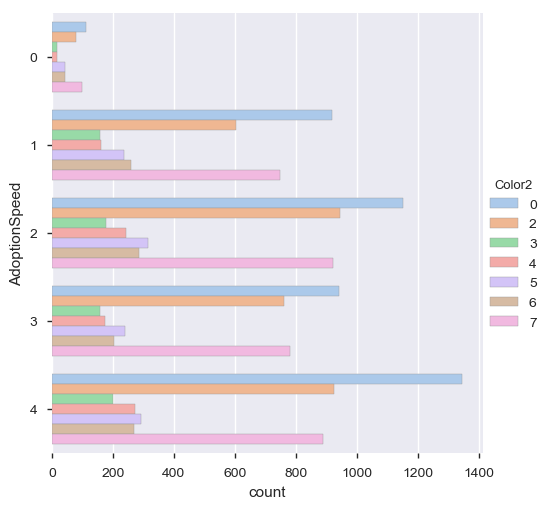

In [68]:
## Horizontal bar chart in Seaborn
sns.catplot(y="AdoptionSpeed", 
            hue="Color2", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=data_r2);

In [69]:
# Cross Tabulation for Categorical Variables 
pd.crosstab(data_r2.AdoptionSpeed, data_r2.Color2, margins=True)

Color2            0     2    3    4     5     6     7    All
AdoptionSpeed                                               
0               112    80   16   18    43    43    98    410
1               920   603  159  162   237   260   749   3090
2              1152   944  176  242   316   286   921   4037
3               941   761  157  174   240   205   781   3259
4              1346   925  202  274   292   269   889   4197
All            4471  3313  710  870  1128  1063  3438  14993

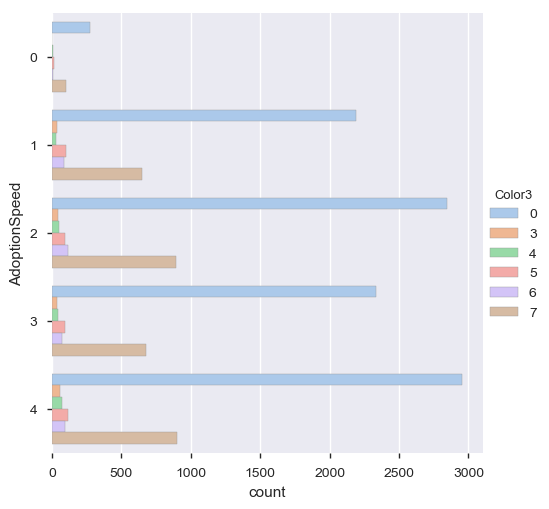

In [70]:
## Horizontal bar chart in Seaborn
sns.catplot(y="AdoptionSpeed", 
            hue="Color3", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=data_r2);

In [71]:
# Cross Tabulation for Categorical Variables 
pd.crosstab(data_r2.AdoptionSpeed, data_r2.Color3, margins=True)

Color3             0    3    4    5    6     7    All
AdoptionSpeed                                        
0                274    3    5   15   10   103    410
1               2189   40   29   99   84   649   3090
2               2848   41   48   94  115   891   4037
3               2337   34   41   94   74   679   3259
4               2956   57   75  115   95   899   4197
All            10604  175  198  417  378  3221  14993

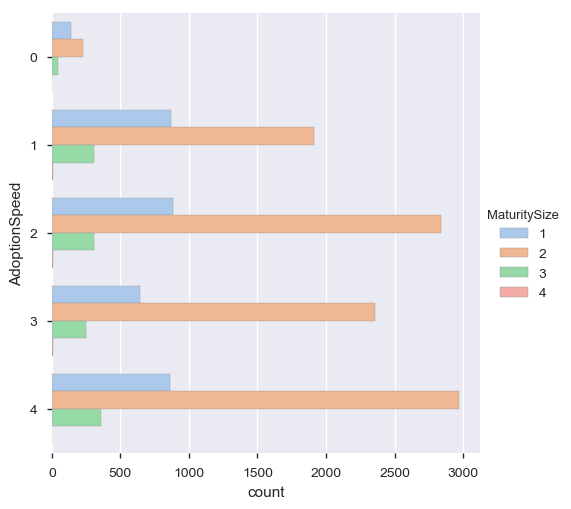

In [72]:
## Horizontal bar chart in Seaborn
sns.catplot(y="AdoptionSpeed", 
            hue="MaturitySize", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=data_r2);

In [73]:
# Cross Tabulation for Categorical Variables 
pd.crosstab(data_r2.AdoptionSpeed, data_r2.MaturitySize, margins=True)

MaturitySize      1      2     3   4    All
AdoptionSpeed                              
0               139    226    43   2    410
1               870   1909   304   7   3090
2               884   2837   305  11   4037
3               641   2360   248  10   3259
4               861   2973   360   3   4197
All            3395  10305  1260  33  14993

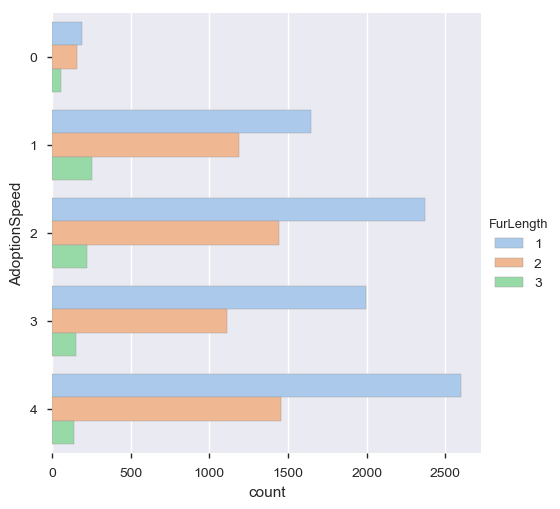

In [74]:
## Horizontal bar chart in Seaborn
sns.catplot(y="AdoptionSpeed", 
            hue="FurLength", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=data_r2);

In [75]:
# Cross Tabulation for Categorical Variables 
pd.crosstab(data_r2.AdoptionSpeed, data_r2.FurLength, margins=True)

FurLength         1     2    3    All
AdoptionSpeed                        
0               194   160   56    410
1              1649  1187  254   3090
2              2372  1444  221   4037
3              1994  1111  154   3259
4              2599  1459  139   4197
All            8808  5361  824  14993

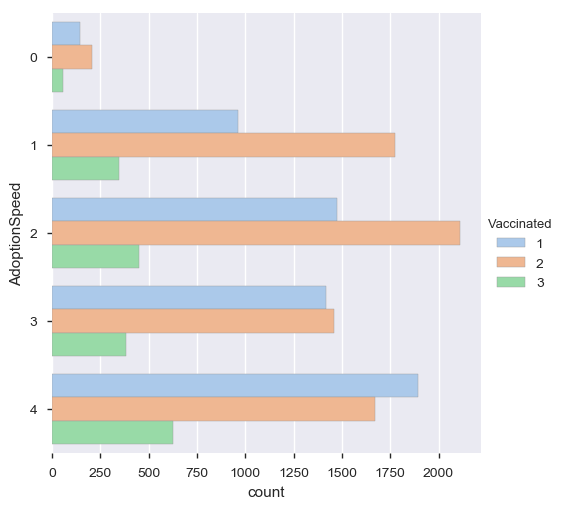

In [76]:
## Horizontal bar chart in Seaborn
sns.catplot(y="AdoptionSpeed", 
            hue="Vaccinated", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=data_r2);

In [77]:
# Cross Tabulation for Categorical Variables 
pd.crosstab(data_r2.AdoptionSpeed, data_r2.Vaccinated, margins=True)

Vaccinated        1     2     3    All
AdoptionSpeed                         
0               146   206    58    410
1               965  1777   348   3090
2              1473  2112   452   4037
3              1419  1459   381   3259
4              1895  1673   629   4197
All            5898  7227  1868  14993

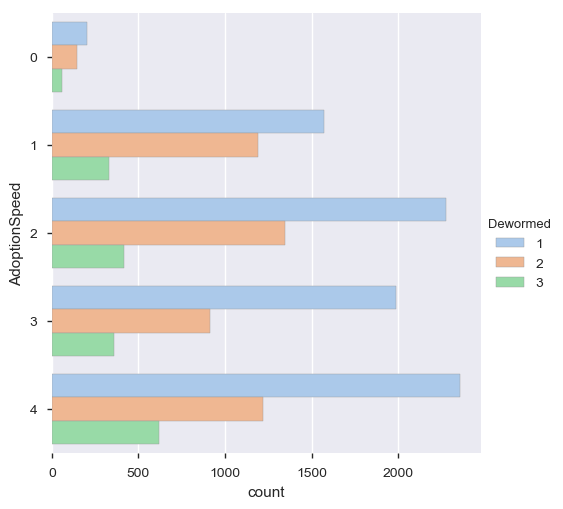

In [78]:
# Horizontal bar chart in Seaborn
sns.catplot(y="AdoptionSpeed", 
            hue="Dewormed", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=data_r2);

In [79]:
# Cross Tabulation for Categorical Variables 
pd.crosstab(data_r2.AdoptionSpeed, data_r2.Dewormed, margins=True)

Dewormed          1     2     3    All
AdoptionSpeed                         
0               205   146    59    410
1              1572  1188   330   3090
2              2273  1347   417   4037
3              1988   914   357   3259
4              2359  1220   618   4197
All            8397  4815  1781  14993

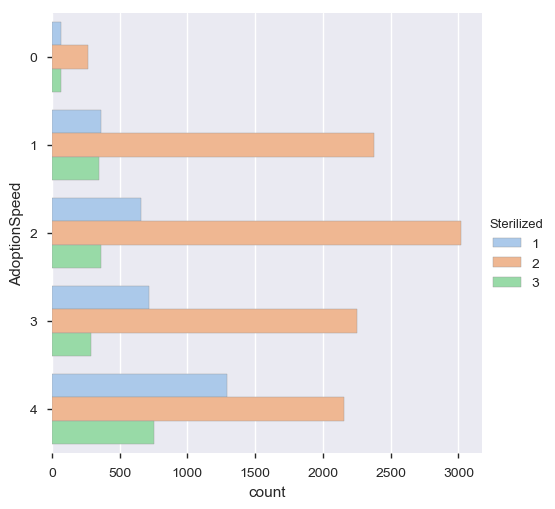

In [80]:
# Horzontal Bar Chart in Seaborn
sns.catplot(y="AdoptionSpeed", 
            hue="Sterilized", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=data_r2);

In [81]:
# Cross Tabulation for Categorical Variables 
pd.crosstab(data_r2.AdoptionSpeed, data_r2.Sterilized, margins=True)

Sterilized        1      2     3    All
AdoptionSpeed                          
0                70    270    70    410
1               364   2378   348   3090
2               656   3022   359   4037
3               720   2251   288   3259
4              1291   2156   750   4197
All            3101  10077  1815  14993

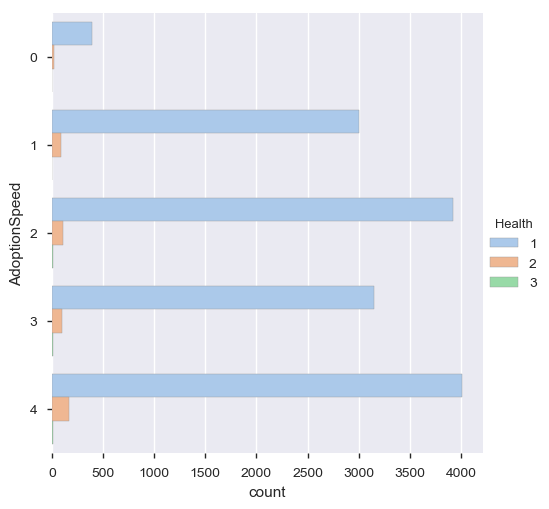

In [82]:
# Horzontal bar chart in Seaborn
sns.catplot(y="AdoptionSpeed", 
            hue="Health", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=data_r2);

In [83]:
# Cross Tabulation for Categorical Variables 
pd.crosstab(data_r2.AdoptionSpeed, data_r2.Health, margins=True)

Health             1    2   3    All
AdoptionSpeed                       
0                392   17   1    410
1               2999   89   2   3090
2               3925  106   6   4037
3               3150   98  11   3259
4               4012  171  14   4197
All            14478  481  34  14993

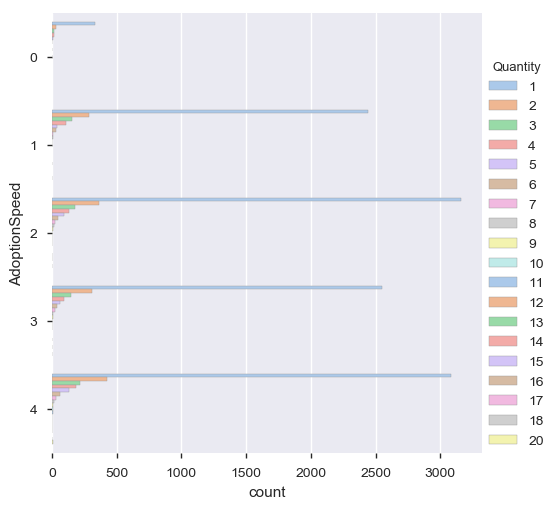

In [84]:
## Horizontal bar chart in Seaborn
sns.catplot(y="AdoptionSpeed", 
            hue="Quantity", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=data_r2);

In [85]:
# Creating a new column for the new binned Quantity variable
data_r2["Quantity_t"]=data_r2["Quantity"]
data_r2.head(1)

Type  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  MaturitySize  \
0     2    3     299       0       1       1       7       0             1   

   FurLength     ...      Health  Quantity  Fee  State  AdoptionSpeed  \
0          1     ...           1         1  100  41326              2   

   AdoptionSpeed_t  AdoptionSpeed_t2     Age_t  Breed1_t  Quantity_t  
0                0                 0  0.477121       275           1  

[1 rows x 23 columns]

In [86]:
## Creating a binary binned Quantity Variable
data_r2.Quantity_t[data_r2.Quantity_t >= 2] = 2
data_r2.head(1)

Type  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  MaturitySize  \
0     2    3     299       0       1       1       7       0             1   

   FurLength     ...      Health  Quantity  Fee  State  AdoptionSpeed  \
0          1     ...           1         1  100  41326              2   

   AdoptionSpeed_t  AdoptionSpeed_t2     Age_t  Breed1_t  Quantity_t  
0                0                 0  0.477121       275           1  

[1 rows x 23 columns]

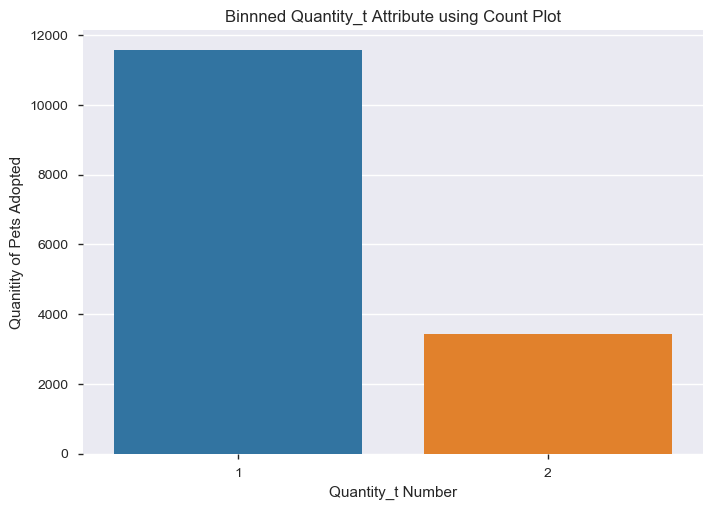

In [87]:
# Bar and Count PLot for the Binned Quantity_t Variable
count, ax = plt.subplots()
ax = sns.countplot('Quantity_t', data=data_r2)
ax.set_title('Binnned Quantity_t Attribute using Count Plot')
ax.set_xlabel('Quantity_t Number')
ax.set_ylabel('Quanitity of Pets Adopted')

plt.show()

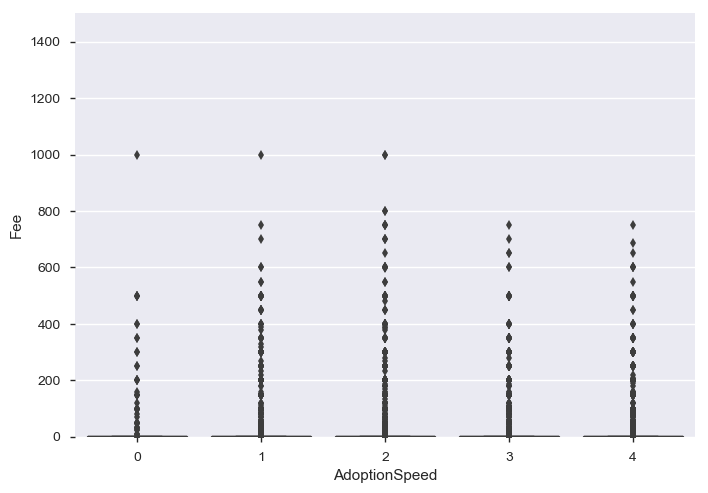

In [88]:
# Box and whisker plot for Fee
fig = sns.boxplot(x='AdoptionSpeed', y="Fee", data=data_r2)
fig.axis(ymin=0, ymax=1500);

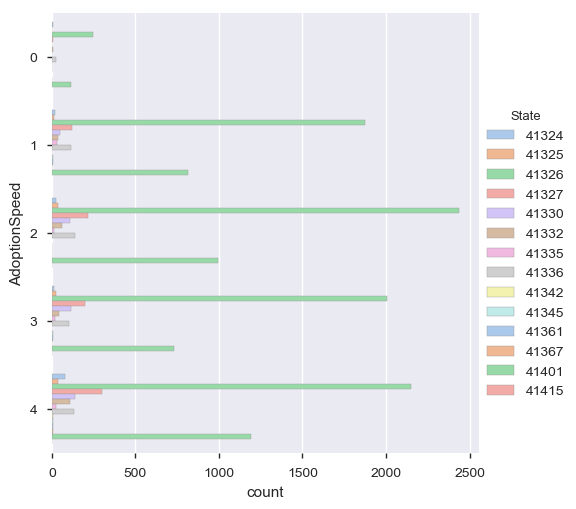

In [89]:
## Horizontal bar chart in Seaborn
sns.catplot(y="AdoptionSpeed", 
            hue="State", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=data_r2);

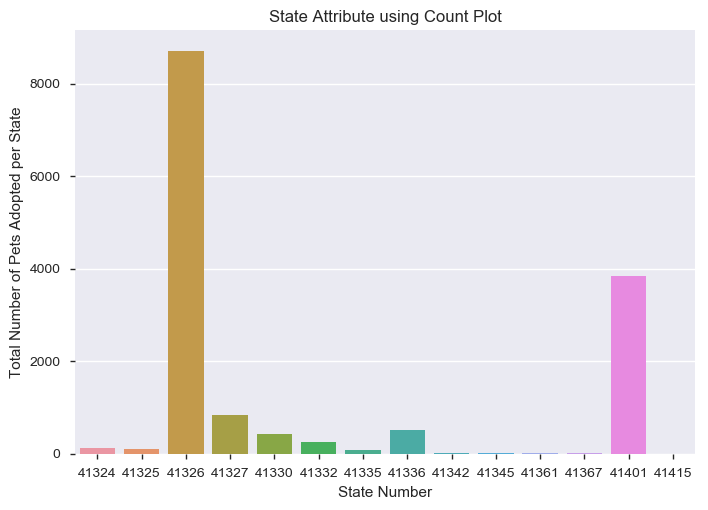

In [90]:
# Bar and Count Plot for the State Variable
count, ax = plt.subplots()
ax = sns.countplot('State', data=data_r2)
ax.set_title('State Attribute using Count Plot')
ax.set_xlabel('State Number')
ax.set_ylabel('Total Number of Pets Adopted per State')

plt.show()

In [91]:
# Cross Tabulation for Categorical Variables 
pd.crosstab(data_r2.AdoptionSpeed, data_r2.State, margins=True)

State          41324  41325  41326  41327  41330  41332  41335  41336  41342  \
AdoptionSpeed                                                                  
0                  4      3    246      8      3      4      3     23      1   
1                 18     14   1877    122     48     36     29    113      1   
2                 23     34   2435    216    111     63     14    136      0   
3                 12     23   2004    197    117     42     16    103      2   
4                 80     36   2152    300    141    108     23    132      9   
All              137    110   8714    843    420    253     85    507     13   

State          41345  41361  41367  41401  41415    All  
AdoptionSpeed                                            
0                  1      0      2    112      0    410  
1                  6      9      3    814      0   3090  
2                  3      2      3    996      1   4037  
3                  4      6      1    731      1   3259  
4                  8      9      6   1192      1   4197  
All               22     26     15   3845      3  14993

In [92]:
# Creating a new column for the Binned State Variable
data_r2["State_t"]=data_r2["State"]
data_r2.head(1)

Type  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  MaturitySize  \
0     2    3     299       0       1       1       7       0             1   

   FurLength   ...     Quantity  Fee  State  AdoptionSpeed  AdoptionSpeed_t  \
0          1   ...            1  100  41326              2                0   

   AdoptionSpeed_t2     Age_t  Breed1_t  Quantity_t  State_t  
0                 0  0.477121       275           1    41326  

[1 rows x 24 columns]

In [93]:
## Binnng the all values that have counts less than 500
data_r2.State_t[data_r2.State_t == 41324] = 41000
data_r2.State_t[data_r2.State_t == 41325] = 41000
data_r2.State_t[data_r2.State_t == 41327] = 41000
data_r2.State_t[data_r2.State_t == 41330] = 41000
data_r2.State_t[data_r2.State_t == 41332] = 41000
data_r2.State_t[data_r2.State_t == 41335] = 41000
data_r2.State_t[data_r2.State_t == 41336] = 41000
data_r2.State_t[data_r2.State_t == 41342] = 41000
data_r2.State_t[data_r2.State_t == 41345] = 41000
data_r2.State_t[data_r2.State_t == 41361] = 41000
data_r2.State_t[data_r2.State_t == 41367] = 41000
data_r2.State_t[data_r2.State_t == 41415] = 41000
 
data_r2.head(1)

Type  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  MaturitySize  \
0     2    3     299       0       1       1       7       0             1   

   FurLength   ...     Quantity  Fee  State  AdoptionSpeed  AdoptionSpeed_t  \
0          1   ...            1  100  41326              2                0   

   AdoptionSpeed_t2     Age_t  Breed1_t  Quantity_t  State_t  
0                 0  0.477121       275           1    41326  

[1 rows x 24 columns]

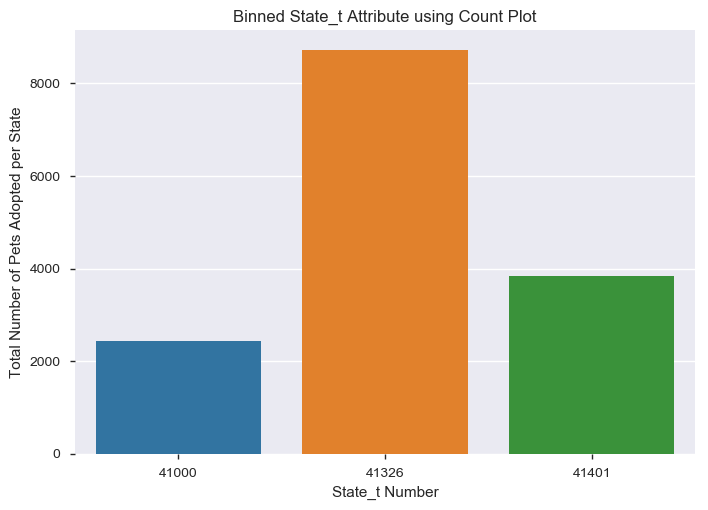

In [94]:
# Bar and count plot for the three factor State_t variable
count, ax = plt.subplots()
ax = sns.countplot('State_t', data=data_r2)
ax.set_title('Binned State_t Attribute using Count Plot')
ax.set_xlabel('State_t Number')
ax.set_ylabel('Total Number of Pets Adopted per State')

plt.show()

In [95]:
################################## Correlations

In [96]:
# dataframe check for data_r2 in Pandas
data_r2.head(3)

Type  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  MaturitySize  \
0     2    3     299       0       1       1       7       0             1   
1     2    1     265       0       1       1       2       0             2   
2     1    1     307       0       1       2       7       0             2   

   FurLength   ...     Quantity  Fee  State  AdoptionSpeed  AdoptionSpeed_t  \
0          1   ...            1  100  41326              2                0   
1          2   ...            1    0  41401              0                0   
2          2   ...            1    0  41326              3                1   

   AdoptionSpeed_t2     Age_t  Breed1_t  Quantity_t  State_t  
0                 0  0.477121       275           1    41326  
1                 0  0.000000       265           1    41401  
2                 0  0.000000       307           1    41326  

[3 rows x 24 columns]

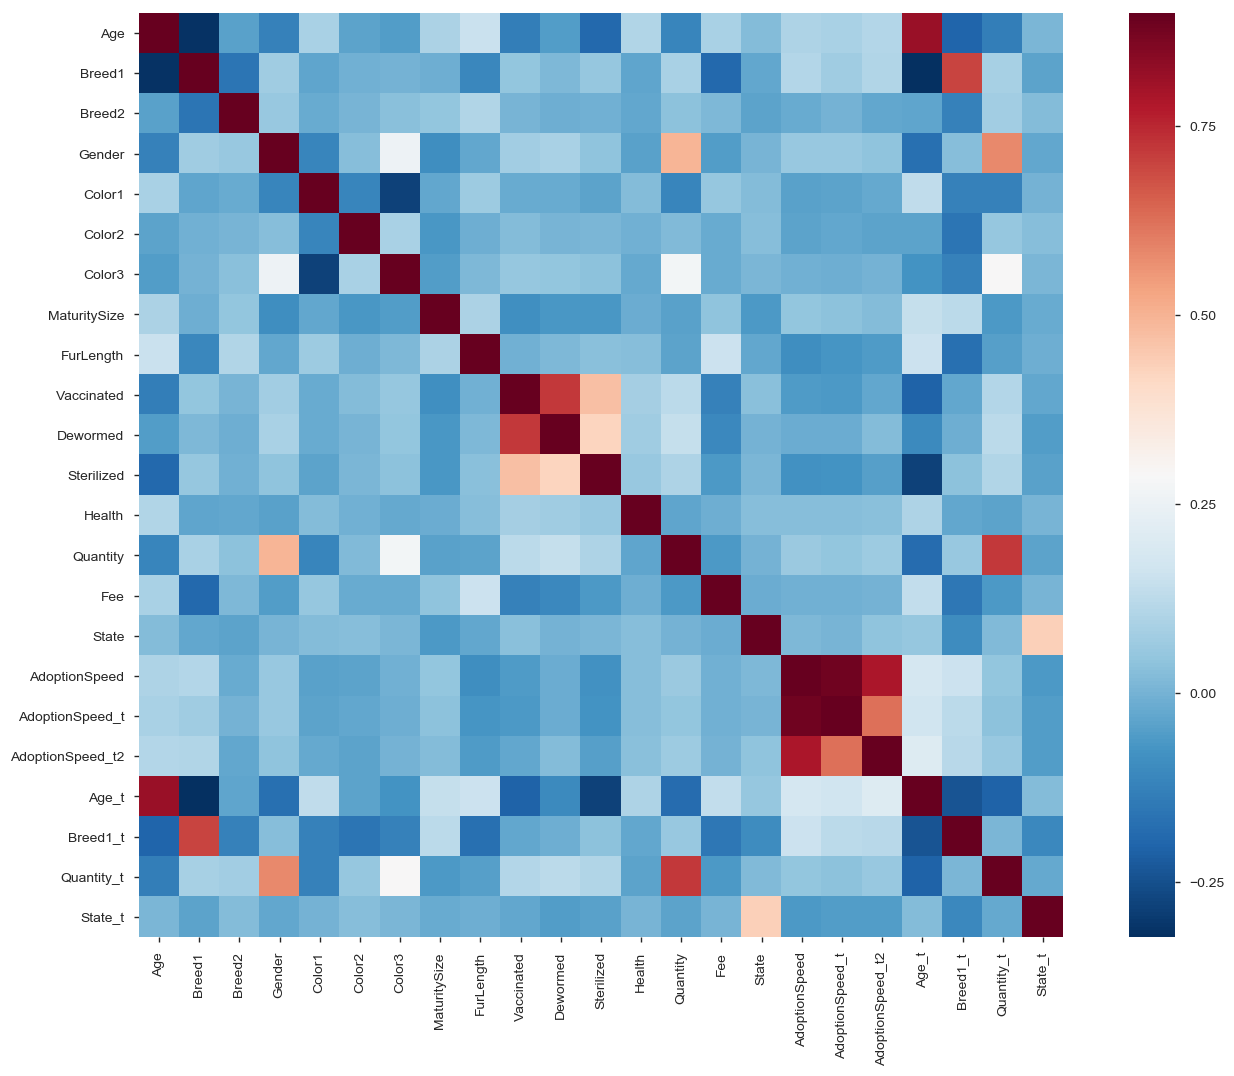

In [97]:
# Correlations matrixbetween dependent variable and independent variables for all numerical datapoints
corr2 = data_r2.select_dtypes(include = ['float64', 'int64']).iloc[:, 1:].corr()
plt.figure(figsize=(17, 12))
sns.heatmap(corr2, vmax = 0.9, cmap = 'RdBu_r', square = True)
plt.show()

In [98]:
# Correlations between dependent variable and independent variables for all numerical datapoints
# Output
corr2 = data_r2.select_dtypes(include = ['float64', 'int64']).iloc[:, 1:].corr()

## rank the correlation
corr_price = corr2['AdoptionSpeed']
corr_df = pd.DataFrame({'Column': corr_price.index, 
                        'Correlation': corr_price,
                        'Abs Value': abs(corr_price)}, index = None)
corr_df = corr_df.drop(['AdoptionSpeed'], axis = 0)
corr_df.set_index('Column', inplace = True)
corr_df = corr_df.rename_axis(None)
corr_df = corr_df.sort_values(by = ['Abs Value'], ascending = [False])
corr_df.iloc[:, 1:2]

Abs Value
AdoptionSpeed_t    0.884132
AdoptionSpeed_t2   0.785748
Age_t              0.183133
Breed1_t           0.159519
Breed1             0.107834
Age                0.100510
FurLength          0.091337
Sterilized         0.083447
Quantity           0.062931
State_t            0.062579
Vaccinated         0.059043
Gender             0.057622
Quantity_t         0.048789
MaturitySize       0.045653
Color1             0.044192
Color2             0.038579
Health             0.029382
Breed2             0.018642
Dewormed           0.013210
State              0.013119
Color3             0.007014
Fee                0.004017

In [99]:
## Correlations Matrix with values
data_r2.corr()

Type       Age    Breed1    Breed2    Gender    Color1  \
Type              1.000000 -0.147162  0.057724 -0.043568  0.060843  0.097680   
Age              -0.147162  1.000000 -0.314346 -0.041010 -0.123423  0.090378   
Breed1            0.057724 -0.314346  1.000000 -0.157053  0.071321 -0.035510   
Breed2           -0.043568 -0.041010 -0.157053  1.000000  0.056907 -0.020324   
Gender            0.060843 -0.123423  0.071321  0.056907  1.000000 -0.115351   
Color1            0.097680  0.090378 -0.035510 -0.020324 -0.115351  1.000000   
Color2            0.246333 -0.039427 -0.007081  0.003015  0.026507 -0.113290   
Color3            0.201693 -0.053546 -0.000682  0.035679  0.259309 -0.282897   
MaturitySize     -0.171811  0.093673 -0.010507  0.049879 -0.091819 -0.029468   
FurLength         0.003036  0.153092 -0.108059  0.106220 -0.030404  0.066967   
Vaccinated        0.102907 -0.136061  0.046518  0.005638  0.078702 -0.017475   
Dewormed          0.025508 -0.053360  0.013216 -0.009817  0.091431 -0.019318   
Sterilized        0.006737 -0.189450  0.052698 -0.005989  0.040645 -0.037050   
Health           -0.006864  0.103215 -0.034893 -0.029285 -0.045177  0.024410   
Quantity          0.036423 -0.113076  0.090194  0.038125  0.494489 -0.116688   
Fee              -0.042134  0.089168 -0.189526  0.013508 -0.050491  0.054180   
State             0.124549  0.024523 -0.026832 -0.037993  0.002564  0.024012   
AdoptionSpeed    -0.091240  0.100510  0.107834 -0.018642  0.057622 -0.044192   
AdoptionSpeed_t  -0.085406  0.092891  0.071457 -0.001286  0.058508 -0.038220   
AdoptionSpeed_t2 -0.041032  0.110439  0.102662 -0.028090  0.043473 -0.024673   
Age_t            -0.092682  0.815327 -0.322320 -0.035530 -0.174045  0.131793   
Breed1_t         -0.570781 -0.200818  0.702403 -0.123558  0.027150 -0.123194   
Quantity_t        0.111353 -0.134733  0.085993  0.076282  0.582162 -0.126385   
State_t           0.106546  0.010435 -0.040573  0.022137 -0.027124  0.000335   

                    Color2    Color3  MaturitySize  FurLength    ...     \
Type              0.246333  0.201693     -0.171811   0.003036    ...      
Age              -0.039427 -0.053546      0.093673   0.153092    ...      
Breed1           -0.007081 -0.000682     -0.010507  -0.108059    ...      
Breed2            0.003015  0.035679      0.049879   0.106220    ...      
Gender            0.026507  0.259309     -0.091819  -0.030404    ...      
Color1           -0.113290 -0.282897     -0.029468   0.066967    ...      
Color2            1.000000  0.088742     -0.065155  -0.008764    ...      
Color3            0.088742  1.000000     -0.051730   0.013581    ...      
MaturitySize     -0.065155 -0.051730      1.000000   0.095142    ...      
FurLength        -0.008764  0.013581      0.095142   1.000000    ...      
Vaccinated        0.026193  0.054053     -0.087722  -0.006010    ...      
Dewormed          0.005812  0.048617     -0.067352   0.016463    ...      
Sterilized        0.007370  0.038899     -0.066321   0.032092    ...      
Health           -0.004307 -0.024782     -0.012957   0.028096    ...      
Quantity          0.019876  0.272548     -0.042832  -0.038388    ...      
Fee              -0.017308 -0.019839      0.041144   0.159693    ...      
State             0.026944  0.010554     -0.062584  -0.029317    ...      
AdoptionSpeed    -0.038579 -0.007014      0.045653  -0.091337    ...      
AdoptionSpeed_t  -0.028916 -0.008506      0.039174  -0.073389    ...      
AdoptionSpeed_t2 -0.036686  0.000508      0.022822  -0.055806    ...      
Age_t            -0.038536 -0.075977      0.141797   0.157857    ...      
Breed1_t         -0.158750 -0.121841      0.125285  -0.173826    ...      
Quantity_t        0.054038  0.292599     -0.061722  -0.048925    ...      
State_t           0.029593  0.009064     -0.018812  -0.007253    ...      

                  Quantity       Fee     State  AdoptionSpeed  \
Type              0.036423 -0.042134  0.124549      -0.091240   
Age            

In [100]:
# Creating correlation dataframe for Vaccinated and Dewormed
data_corr=data_r2[["Vaccinated", "Dewormed"]]

In [101]:
## Correlations Matrix with values
data_corr.corr()

Vaccinated  Dewormed
Vaccinated    1.000000  0.722596
Dewormed      0.722596  1.000000

In [102]:
## Anovas Tables for the top attributes selected for this study

In [103]:
print(stats.normaltest(data_r2['AdoptionSpeed'], axis=0))

NormaltestResult(statistic=8103.596911855624, pvalue=0.0)


In [104]:
# Running OLS Models for select input variable against the target 
results = ols('AdoptionSpeed ~ C(Age)', data=data_r2).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          AdoptionSpeed   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     8.274
Date:                Sun, 28 Jul 2019   Prob (F-statistic):          2.10e-116
Time:                        13:49:17   Log-Likelihood:                -23295.
No. Observations:               14993   AIC:                         4.680e+04
Df Residuals:                   14887   BIC:                         4.761e+04
Df Model:                         105                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         2.2291      0.086     25.969      0.000       2.061       2.397
C(Age)[T.1]      -0.0363      0.089     -0.408      0.683      -0.211       0.138
C(Age)[T.2]       0.0359      0.088      0.408      0.684      -0.137       0.208
C(Age)[T.3]       0.2297      0.090      2.563      0.010       0.054       0.405
C(Age)[T.4]       0.4012      0.093      4.338      0.000       0.220       0.583
C(Age)[T.5]       0.4651      0.098      4.751      0.000       0.273       0.657
C(Age)[T.6]       0.5720      0.099      5.799      0.000       0.379       0.765
C(Age)[T.7]       0.5717      0.110      5.205      0.000       0.356       0.787
C(Age)[T.8]       0.7030      0.108      6.517      0.000       0.492       0.914
C(Age)[T.9]       0.5481      0.121      4.546      0.000       0.312       0.784
C(Age)[T.10]      0.5240      0.125      4.208      0.000       0.280       0.768
C(Age)[T.11]      0.8348      0.146      5.707      0.000       0.548       1.122
C(Age)[T.12]      0.6541      0.093      7.000      0.000       0.471       0.837
C(Age)[T.13]      0.4959      0.201      2.469      0.014       0.102       0.890
C(Age)[T.14]      0.6525      0.157      4.150      0.000       0.344       0.961
C(Age)[T.15]      0.4545      0.155      2.930      0.003       0.150       0.759
C(Age)[T.16]      0.6909      0.184      3.761      0.000       0.331       1.051
C(Age)[T.17]      0.5620      0.164      3.417      0.001       0.240       0.884
C(Age)[T.18]      0.4194      0.124      3.384      0.001       0.177       0.662
C(Age)[T.19]      0.4248      0.241      1.763      0.078      -0.048       0.897
C(Age)[T.20]      0.5209      0.220      2.364      0.018       0.089       0.953
C(Age)[T.21]      0.8067      0.233      3.456      0.001       0.349       1.264
C(Age)[T.22]      0.5604      0.277      2.023      0.043       0.017       1.104
C(Age)[T.23]      0.3959      0.415      0.954      0.340      -0.417       1.209
C(Age)[T.24]      0.6481      0.097      6.687      0.000       0.458       0.838
C(Age)[T.25]      0.6709      0.373      1.798      0.072      -0.060       1.402
C(Age)[T.26]      1.2325      0.330      3.736      0.000       0.586       1.879
C(Age)[T.27]      0.6533      0.291      2.242      0.025       0.082       1.225
C(Age)[T.28]      0.2325      0.330      0.705      0.481      -0.414       0.879
C(Age)[T.29]      0.7309      0.245      2.981      0.003       0.250       1.212
C(Age)[T.30]      0.3094      0.181      1.710      0.087      -0.045       0.664
C(Age)[T.31]      1.1043      0.392      2.815      0.005       0.335       1.873
C(Age)[T.32]      0.2376      0.309      0.770      0.441      -0.367       0.843
C(Age)[T.33]      0.7709      0.581      1.328      0.184      -0.367       1.909
C(Age)[T.34]      0.9709      0.521      1.865   

In [105]:
# Running the Tukey Comparison of the Means Models
mc = MultiComparison(data_r2['AdoptionSpeed'], data_r2['Age'])
tkresult = mc.tukeyhsd()
 
print(tkresult)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper  reject
----------------------------------------------
  0      1    -0.0363  -0.4221   0.3494 False 
  0      2     0.0359  -0.3451   0.4169 False 
  0      3     0.2297  -0.1584   0.6179 False 
  0      4     0.4012   0.0008   0.8017  True 
  0      5     0.4651   0.0412   0.8889  True 
  0      6     0.572    0.1449   0.9991  True 
  0      7     0.5717   0.0962   1.0471  True 
  0      8     0.703    0.236     1.17   True 
  0      9     0.5481   0.0262   1.0701  True 
  0      10    0.524   -0.0151   1.0632 False 
  0      11    0.8348   0.2015   1.4681  True 
  0      12    0.6541   0.2495   1.0586  True 
  0      13    0.4959  -0.3736   1.3655 False 
  0      14    0.6525  -0.0282   1.3332 False 
  0      15    0.4545  -0.2171   1.1261 False 
  0      16    0.6909  -0.1044   1.4863 False 
  0      17    0.562   -0.1501   1.2741 False 
  0      18    0.4194  -0.1171   0.956  False 
  0      

In [106]:
# Running OLS Models for select input variable against the target 
results = ols('AdoptionSpeed ~ C(Breed1_t)', data=data_r2).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          AdoptionSpeed   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     131.8
Date:                Sun, 28 Jul 2019   Prob (F-statistic):           2.87e-84
Time:                        13:49:19   Log-Likelihood:                -23525.
No. Observations:               14993   AIC:                         4.706e+04
Df Residuals:                   14989   BIC:                         4.709e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.3069      0.023    102.107      0.000       2.263       2.351
C(Breed1_t)[T.265]     0.0341      0.040      0.858      0.391      -0.044       0.112
C(Breed1_t)[T.275]     0.0961      0.028      3.458      0.001       0.042       0.151
C(Breed1_t)[T.307]     0.4392      0.027     16.164      0.000       0.386       0.492
==============================================================================
Omnibus:                     6294.765   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              804.112
Skew:                          -0.134   Prob(JB):                    2.45e-175
Kurtosis:                       1.898   Cond. No.                         6.04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [107]:
# Running the Tukey Comparison of the Means Models
mc = MultiComparison(data_r2['AdoptionSpeed'], data_r2['Breed1_t'])
tkresult = mc.tukeyhsd()
 
print(tkresult)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
 260    265    0.0341  -0.0681 0.1363 False 
 260    275    0.0961   0.0247 0.1675  True 
 260    307    0.4392   0.3694 0.509   True 
 265    275    0.062   -0.0318 0.1558 False 
 265    307    0.4051   0.3125 0.4977  True 
 275    307    0.3431   0.2862 0.3999  True 
--------------------------------------------


In [108]:
# Running the Tukey Comparison of the Means Models
mc = MultiComparison(data_r2['AdoptionSpeed'], data_r2['Breed2'])
tkresult = mc.tukeyhsd()
 
print(tkresult)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper  reject
----------------------------------------------
  0      1    -0.5385  -5.7269    4.65  False 
  0      2    -1.5385  -6.7269    3.65  False 
  0      4    -1.5385  -6.7269    3.65  False 
  0      5    -2.0385  -5.7074   1.6305 False 
  0      10   -0.0385  -3.7074   3.6305 False 
  0      14    0.9615  -2.7074   4.6305 False 
  0      16   -1.0385  -4.7074   2.6305 False 
  0      17    1.4615  -3.7269    6.65  False 
  0      18    0.4615  -2.5343   3.4574 False 
  0      19   -0.0385  -3.7074   3.6305 False 
  0      20   -0.6635  -1.9615   0.6345 False 
  0      21    0.7949   -2.201   3.7907 False 
  0      24   -1.5385  -4.5343   1.4574 False 
  0      25   -1.5385  -6.7269    3.65  False 
  0      26   -0.4208  -1.6801   0.8385 False 
  0      36    0.4615  -4.7269    5.65  False 
  0      39    0.007   -1.5581   1.5721 False 
  0      40    0.4615  -4.7269    5.65  False 
  0      

In [109]:
# Running the Tukey Comparison of the Means Models
mc = MultiComparison(data_r2['AdoptionSpeed'], data_r2['Breed2'])
tkresult = mc.tukeyhsd()
 
print(tkresult)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper  reject
----------------------------------------------
  0      1    -0.5385  -5.7269    4.65  False 
  0      2    -1.5385  -6.7269    3.65  False 
  0      4    -1.5385  -6.7269    3.65  False 
  0      5    -2.0385  -5.7074   1.6305 False 
  0      10   -0.0385  -3.7074   3.6305 False 
  0      14    0.9615  -2.7074   4.6305 False 
  0      16   -1.0385  -4.7074   2.6305 False 
  0      17    1.4615  -3.7269    6.65  False 
  0      18    0.4615  -2.5343   3.4574 False 
  0      19   -0.0385  -3.7074   3.6305 False 
  0      20   -0.6635  -1.9615   0.6345 False 
  0      21    0.7949   -2.201   3.7907 False 
  0      24   -1.5385  -4.5343   1.4574 False 
  0      25   -1.5385  -6.7269    3.65  False 
  0      26   -0.4208  -1.6801   0.8385 False 
  0      36    0.4615  -4.7269    5.65  False 
  0      39    0.007   -1.5581   1.5721 False 
  0      40    0.4615  -4.7269    5.65  False 
  0      

In [110]:
# Running OLS Models for select input variable against the target 
results = ols('AdoptionSpeed ~ C(Sterilized)', data=data_r2).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          AdoptionSpeed   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     290.5
Date:                Sun, 28 Jul 2019   Prob (F-statistic):          1.61e-124
Time:                        13:49:23   Log-Likelihood:                -23435.
No. Observations:               14993   AIC:                         4.688e+04
Df Residuals:                   14990   BIC:                         4.690e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.9023      0.021    139.909      0.000       2.862       2.943
C(Sterilized)[T.2]    -0.5406      0.024    -22.788      0.000      -0.587      -0.494
C(Sterilized)[T.3]    -0.1860      0.034     -5.449      0.000      -0.253      -0.119
==============================================================================
Omnibus:                     3404.942   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              704.761
Skew:                          -0.187   Prob(JB):                    9.19e-154
Kurtosis:                       2.006   Cond. No.                         5.36
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [111]:
# Running the Tukey Comparison of the Means Models
mc = MultiComparison(data_r2['AdoptionSpeed'], data_r2['Sterilized'])
tkresult = mc.tukeyhsd()
 
print(tkresult)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  1      2    -0.5406  -0.5962 -0.485  True 
  1      3     -0.186  -0.2661 -0.106  True 
  2      3     0.3545   0.2855 0.4236  True 
--------------------------------------------


In [112]:
# Running OLS Models for select input variable against the target 
results = ols('AdoptionSpeed ~ C(Quantity)', data=data_r2).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          AdoptionSpeed   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     4.018
Date:                Sun, 28 Jul 2019   Prob (F-statistic):           1.92e-08
Time:                        13:49:23   Log-Likelihood:                -23684.
No. Observations:               14993   AIC:                         4.741e+04
Df Residuals:                   14974   BIC:                         4.755e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             2.4852      0.011    227.426      0.000       2.464       2.507
C(Quantity)[T.2]      0.0795      0.033      2.408      0.016       0.015       0.144
C(Quantity)[T.3]      0.0493      0.045      1.096      0.273      -0.039       0.137
C(Quantity)[T.4]      0.1495      0.052      2.866      0.004       0.047       0.252
C(Quantity)[T.5]      0.3166      0.065      4.848      0.000       0.189       0.445
C(Quantity)[T.6]      0.2662      0.087      3.057      0.002       0.095       0.437
C(Quantity)[T.7]      0.3482      0.129      2.706      0.007       0.096       0.600
C(Quantity)[T.8]      0.1494      0.163      0.915      0.360      -0.171       0.470
C(Quantity)[T.9]      0.2724      0.205      1.330      0.184      -0.129       0.674
C(Quantity)[T.10]     0.5675      0.270      2.103      0.035       0.039       1.096
C(Quantity)[T.11]     0.8148      0.372      2.192      0.028       0.086       1.544
C(Quantity)[T.12]     0.5148      0.480      1.073      0.283      -0.426       1.455
C(Quantity)[T.13]     0.5148      0.831      0.620      0.536      -1.114       2.144
C(Quantity)[T.14]     1.5148      0.831      1.823      0.068      -0.114       3.144
C(Quantity)[T.15]     0.5148      0.588      0.876      0.381      -0.637       1.667
C(Quantity)[T.16]     0.1815      0.679      0.267      0.789      -1.149       1.512
C(Quantity)[T.17]    -0.1518      0.679     -0.224      0.823      -1.482       1.178
C(Quantity)[T.18]     1.5148      1.175      1.289      0.197      -0.789       3.818
C(Quantity)[T.20]     0.8482      0.339      2.499      0.012       0.183       1.513
==============================================================================
Omnibus:                     7608.334   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              858.045
Skew:                          -0.155   Prob(JB):                    4.76e-187
Kurtosis:                       1.870   Cond. No.                         123.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [113]:
# Running the Tukey Comparison of the Means Models
mc = MultiComparison(data_r2['AdoptionSpeed'], data_r2['Quantity'])
tkresult = mc.tukeyhsd()
 
print(tkresult)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  1      2     0.0795  -0.0366 0.1957 False 
  1      3     0.0493  -0.1089 0.2074 False 
  1      4     0.1495   -0.034 0.333  False 
  1      5     0.3166   0.0869 0.5464  True 
  1      6     0.2662  -0.0402 0.5725 False 
  1      7     0.3482  -0.1045 0.8009 False 
  1      8     0.1494  -0.4251 0.724  False 
  1      9     0.2724  -0.4483 0.9931 False 
  1      10    0.5675  -0.3817 1.5166 False 
  1      11    0.8148   -0.493 2.1227 False 
  1      12    0.5148  -1.1733 2.203  False 
  1      13    0.5148  -2.4086 3.4383 False 
  1      14    1.5148  -1.4086 4.4383 False 
  1      15    0.5148  -1.5525 2.5822 False 
  1      16    0.1815  -2.2056 2.5686 False 
  1      17   -0.1518  -2.5389 2.2352 False 
  1      18    1.5148  -2.6193 5.649  False 
  1      20    0.8482  -0.3458 2.0422 False 
  2      3    -0.0303  -0.2188 0.1583 False 
  2 

In [114]:
# Running OLS Models for select input variable against the target 
results = ols('AdoptionSpeed ~ C(State)', data=data_r2).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          AdoptionSpeed   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     12.71
Date:                Sun, 28 Jul 2019   Prob (F-statistic):           2.51e-28
Time:                        13:49:23   Log-Likelihood:                -23638.
No. Observations:               14993   AIC:                         4.730e+04
Df Residuals:                   14979   BIC:                         4.741e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             3.0657      0.100     30.634      0.000       2.870       3.262
C(State)[T.41325]    -0.3839      0.150     -2.560      0.010      -0.678      -0.090
C(State)[T.41326]    -0.6137      0.101     -6.084      0.000      -0.811      -0.416
C(State)[T.41327]    -0.2840      0.108     -2.632      0.009      -0.495      -0.072
C(State)[T.41330]    -0.2443      0.115     -2.120      0.034      -0.470      -0.018
C(State)[T.41332]    -0.2198      0.124     -1.769      0.077      -0.463       0.024
C(State)[T.41335]    -0.7480      0.162     -4.625      0.000      -1.065      -0.431
C(State)[T.41336]    -0.6554      0.113     -5.811      0.000      -0.877      -0.434
C(State)[T.41342]     0.2420      0.340      0.712      0.477      -0.424       0.908
C(State)[T.41345]    -0.5202      0.269     -1.934      0.053      -1.048       0.007
C(State)[T.41361]    -0.4888      0.251     -1.951      0.051      -0.980       0.002
C(State)[T.41367]    -0.6657      0.319     -2.090      0.037      -1.290      -0.041
C(State)[T.41401]    -0.5255      0.102     -5.160      0.000      -0.725      -0.326
C(State)[T.41415]    -0.0657      0.684     -0.096      0.923      -1.406       1.274
==============================================================================
Omnibus:                     6821.652   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              835.702
Skew:                          -0.155   Prob(JB):                    3.39e-182
Kurtosis:                       1.886   Cond. No.                         86.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
mc = MultiComparison(data_r['AdoptionSpeed'], data_r['State'])
tkresult = mc.tukeyhsd()
 
print(tkresult)

In [115]:
# Running OLS Models for select input variable against the target 
results = ols('AdoptionSpeed ~ C(Color1)', data=data_r2).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          AdoptionSpeed   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     9.319
Date:                Sun, 28 Jul 2019   Prob (F-statistic):           3.17e-10
Time:                        13:49:23   Log-Likelihood:                -23692.
No. Observations:               14993   AIC:                         4.740e+04
Df Residuals:                   14986   BIC:                         4.745e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.5336      0.014    185.777      0.000       2.507       2.560
C(Color1)[T.2]     0.0507      0.024      2.152      0.031       0.005       0.097
C(Color1)[T.3]    -0.1207      0.041     -2.977      0.003      -0.200      -0.041
C(Color1)[T.4]     0.0358      0.049      0.736      0.462      -0.060       0.131
C(Color1)[T.5]    -0.1818      0.042     -4.347      0.000      -0.264      -0.100
C(Color1)[T.6]    -0.1520      0.047     -3.237      0.001      -0.244      -0.060
C(Color1)[T.7]    -0.1363      0.048     -2.869      0.004      -0.229      -0.043
==============================================================================
Omnibus:                     7444.052   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              853.477
Skew:                          -0.154   Prob(JB):                    4.67e-186
Kurtosis:                       1.873   Cond. No.                         5.95
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [116]:
# Running the Tukey Comparison of the Means Models
mc = MultiComparison(data_r2['AdoptionSpeed'], data_r2['Color1'])
tkresult = mc.tukeyhsd()
 
print(tkresult)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  1      2     0.0507  -0.0188  0.1201 False 
  1      3    -0.1207  -0.2403 -0.0011  True 
  1      4     0.0358  -0.1076  0.1792 False 
  1      5    -0.1818  -0.3051 -0.0585  True 
  1      6     -0.152  -0.2905 -0.0135  True 
  1      7    -0.1363  -0.2764  0.0038 False 
  2      3    -0.1714  -0.2974 -0.0453  True 
  2      4    -0.0149  -0.1637  0.134  False 
  2      5    -0.2325   -0.362 -0.1029  True 
  2      6    -0.2027  -0.3468 -0.0586  True 
  2      7     -0.187  -0.3326 -0.0413  True 
  3      4     0.1565  -0.0213  0.3344 False 
  3      5    -0.0611  -0.2232  0.101  False 
  3      6    -0.0313  -0.2052  0.1426 False 
  3      7    -0.0156  -0.1908  0.1596 False 
  4      5    -0.2176   -0.398 -0.0372  True 
  4      6    -0.1878  -0.3789  0.0032 False 
  4      7    -0.1721  -0.3643  0.0201 False 
  5      6     0.0298  -0.146

In [117]:
# Running OLS Models for select input variable against the target 
results = ols('AdoptionSpeed ~ C(Color2)', data=data_r2).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          AdoptionSpeed   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     6.575
Date:                Sun, 28 Jul 2019   Prob (F-statistic):           5.96e-07
Time:                        13:49:23   Log-Likelihood:                -23701.
No. Observations:               14993   AIC:                         4.742e+04
Df Residuals:                   14986   BIC:                         4.747e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.5567      0.018    145.376      0.000       2.522       2.591
C(Color2)[T.2]     0.0011      0.027      0.041      0.967      -0.052       0.054
C(Color2)[T.3]    -0.0356      0.048     -0.749      0.454      -0.129       0.058
C(Color2)[T.4]     0.0456      0.044      1.046      0.295      -0.040       0.131
C(Color2)[T.5]    -0.1125      0.039     -2.872      0.004      -0.189      -0.036
C(Color2)[T.6]    -0.1832      0.040     -4.566      0.000      -0.262      -0.105
C(Color2)[T.7]    -0.0872      0.027     -3.271      0.001      -0.140      -0.035
==============================================================================
Omnibus:                     7942.342   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              865.551
Skew:                          -0.153   Prob(JB):                    1.12e-188
Kurtosis:                       1.863   Cond. No.                         6.39
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [118]:
# Running the Tukey Comparison of the Means Models
mc = MultiComparison(data_r2['AdoptionSpeed'], data_r2['Color2'])
tkresult = mc.tukeyhsd()
 
print(tkresult)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  0      2     0.0011  -0.0784  0.0806 False 
  0      3    -0.0356  -0.1757  0.1045 False 
  0      4     0.0456  -0.0829  0.1741 False 
  0      5    -0.1125  -0.2281  0.003  False 
  0      6    -0.1832  -0.3016 -0.0649  True 
  0      7    -0.0872  -0.1659 -0.0086  True 
  2      3    -0.0367  -0.1801  0.1067 False 
  2      4     0.0445  -0.0876  0.1766 False 
  2      5    -0.1137  -0.2332  0.0059 False 
  2      6    -0.1843  -0.3066 -0.0621  True 
  2      7    -0.0883  -0.1728 -0.0039  True 
  3      4     0.0812  -0.0942  0.2565 False 
  3      5     -0.077  -0.2431  0.0891 False 
  3      6    -0.1477  -0.3157  0.0204 False 
  3      7    -0.0517  -0.1946  0.0913 False 
  4      5    -0.1581  -0.3146 -0.0017  True 
  4      6    -0.2288  -0.3874 -0.0703  True 
  4      7    -0.1328  -0.2644 -0.0012  True 
  5      6    -0.0707  -0.218

In [119]:
# Running OLS Models for select input variable against the target 
results = ols('AdoptionSpeed ~ C(Gender)', data=data_r2).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          AdoptionSpeed   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     30.52
Date:                Sun, 28 Jul 2019   Prob (F-statistic):           5.91e-14
Time:                        13:49:25   Log-Likelihood:                -23690.
No. Observations:               14993   AIC:                         4.739e+04
Df Residuals:                   14990   BIC:                         4.741e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.4187      0.016    153.166      0.000       2.388       2.450
C(Gender)[T.2]     0.1512      0.021      7.214      0.000       0.110       0.192
C(Gender)[T.3]     0.1675      0.030      5.639      0.000       0.109       0.226
==============================================================================
Omnibus:                     7300.711   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              849.911
Skew:                          -0.155   Prob(JB):                    2.78e-185
Kurtosis:                       1.876   Cond. No.                         3.99
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [120]:
# Running the Tukey Comparison of the Means Models
mc = MultiComparison(data_r2['AdoptionSpeed'], data_r2['Gender'])
tkresult = mc.tukeyhsd()
 
print(tkresult)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  1      2     0.1512   0.102  0.2003  True 
  1      3     0.1675   0.0979 0.2372  True 
  2      3     0.0164  -0.0509 0.0836 False 
--------------------------------------------


In [121]:
# Running OLS Models for select input variable against the target 
results = ols('AdoptionSpeed ~ C(Type)', data=data_r2).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          AdoptionSpeed   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     125.8
Date:                Sun, 28 Jul 2019   Prob (F-statistic):           4.34e-29
Time:                        13:49:26   Log-Likelihood:                -23658.
No. Observations:               14993   AIC:                         4.732e+04
Df Residuals:                   14991   BIC:                         4.733e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.6151      0.013    201.147      0.000       2.590       2.641
C(Type)[T.2]    -0.2156      0.019    -11.218      0.000      -0.253      -0.178
==============================================================================
Omnibus:                     7191.790   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              837.816
Skew:                          -0.143   Prob(JB):                    1.18e-182
Kurtosis:                       1.878   Cond. No.                         2.53
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [122]:
# Running the Tukey Comparison of the Means Models
mc = MultiComparison(data_r2['AdoptionSpeed'], data_r2['Type'])
tkresult = mc.tukeyhsd()
 
print(tkresult)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  1      2    -0.2156  -0.2533 -0.1779  True 
---------------------------------------------


In [123]:
# Running OLS Models for select input variable against the target 
results = ols('AdoptionSpeed ~ C(Vaccinated)', data=data_r2).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          AdoptionSpeed   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     122.9
Date:                Sun, 28 Jul 2019   Prob (F-statistic):           1.11e-53
Time:                        13:49:27   Log-Likelihood:                -23598.
No. Observations:               14993   AIC:                         4.720e+04
Df Residuals:                   14990   BIC:                         4.723e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.6701      0.015    175.591      0.000       2.640       2.700
C(Vaccinated)[T.2]    -0.3081      0.020    -15.034      0.000      -0.348      -0.268
C(Vaccinated)[T.3]    -0.0410      0.031     -1.324      0.186      -0.102       0.020
==============================================================================
Omnibus:                     5463.460   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              791.315
Skew:                          -0.160   Prob(JB):                    1.47e-172
Kurtosis:                       1.921   Cond. No.                         4.04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [124]:
# Running the Tukey Comparison of the Means Models
mc = MultiComparison(data_r2['AdoptionSpeed'], data_r2['Vaccinated'])
tkresult = mc.tukeyhsd()
 
print(tkresult)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  1      2    -0.3081  -0.3561 -0.26   True 
  1      3     -0.041  -0.1137 0.0316 False 
  2      3     0.267    0.196  0.3381  True 
--------------------------------------------


In [125]:
## Preliminary Logistic Regression for all 17 input variables

In [126]:
## Models for the splitting the samples into train_test
from sklearn.model_selection import train_test_split

## Models for Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [127]:
## Dropping Non Numerical Attributes
data_r3 = data_r2.drop(['AdoptionSpeed_t', "AdoptionSpeed_t2", "Age_t","Breed1_t", "Quantity_t", "State_t"],  axis=1)
data_r3.columns

Index(['Type', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'AdoptionSpeed'],
      dtype='object')

In [128]:
# separating our independent and dependent variable
X = data_r3.drop(['AdoptionSpeed'], axis = 1)
y = data_r3["AdoptionSpeed"]

In [129]:
## Splitting the data into the training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .35, random_state = 0)

In [130]:
# scikit logistic models

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=0)

logreg = LogisticRegression(C=1, 
                            class_weight=None, 
                            dual=False, 
                            fit_intercept=True,
                            intercept_scaling=1, 
                            max_iter=100, 
                            multi_class='warn',
                            n_jobs=None, penalty='l1', 
                            random_state=None, solver='warn',
                            tol=0.0001, verbose=0, 
                            warm_start=False)

logreg.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [131]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.33


In [132]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[  0  30  41   5  61]
 [  0 186 483  62 388]
 [  0 165 525  75 677]
 [  0  98 372  92 543]
 [  0  92 348  64 941]]


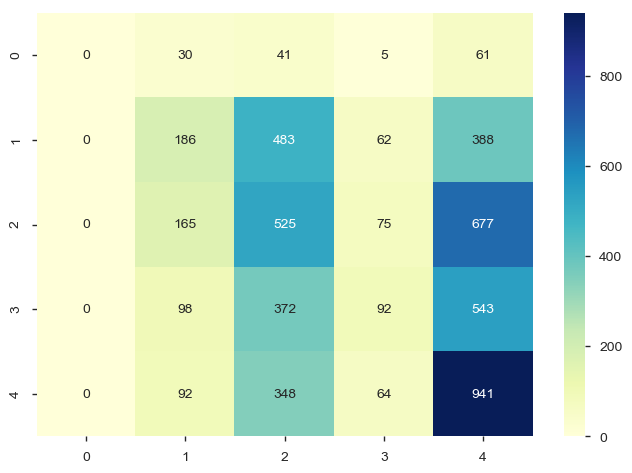

In [133]:
# visualize confusion matrix with seaborn library
sns.heatmap(confusion_matrix,annot=True,fmt="d",  cmap="YlGnBu")
plt.show()

In [134]:
## Loading and printing the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       137
           1       0.33      0.17      0.22      1119
           2       0.30      0.36      0.33      1442
           3       0.31      0.08      0.13      1105
           4       0.36      0.65      0.46      1445

   micro avg       0.33      0.33      0.33      5248
   macro avg       0.26      0.25      0.23      5248
weighted avg       0.32      0.33      0.29      5248



In [135]:
## dropping the variables from the baseline model to create optimized model
data_r4 = data_r2[['Breed1_t', 'Age', 'Type', 'FurLength', 'Sterilized', 'Quantity_t', 'Vaccinated', 'Gender', 
                   'AdoptionSpeed_t']]
data_r4.columns

Index(['Breed1_t', 'Age', 'Type', 'FurLength', 'Sterilized', 'Quantity_t',
       'Vaccinated', 'Gender', 'AdoptionSpeed_t'],
      dtype='object')

In [136]:
# separating our independent and dependent variable
X2 = data_r4.drop(['AdoptionSpeed_t'], axis = 1)
y2 = data_r4["AdoptionSpeed_t"]

In [137]:
# Setting up the Logistic Regression for the Optimized Model
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.35, random_state=0)

logreg = LogisticRegression(C=1, 
                            class_weight=None, 
                            dual=False, 
                            fit_intercept=True,
                            intercept_scaling=1, 
                            max_iter=100, 
                            multi_class='warn',
                            n_jobs=None, penalty='l1', 
                            random_state=None, solver='warn',
                            tol=0.0001, verbose=0, 
                            warm_start=False)

logreg.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [138]:
# Printing the Logistic Regression Results
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.58


In [139]:
#Printing the Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[1547 1151]
 [1035 1515]]


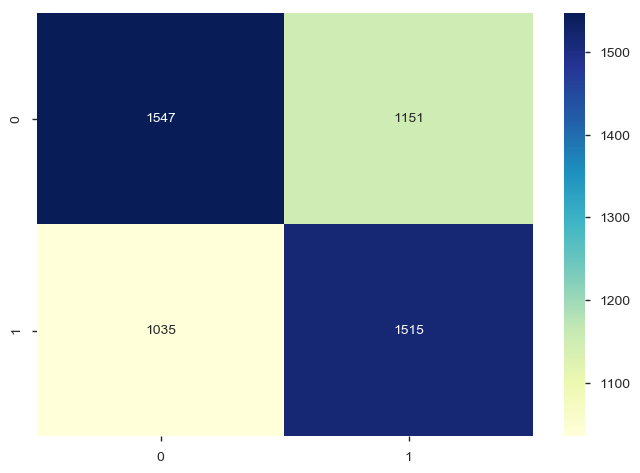

In [140]:
# visualize the confusion matrix with seaborn library
sns.heatmap(confusion_matrix,annot=True,fmt="d", cmap="YlGnBu") 
plt.show()

In [141]:
# Printing the classfication Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.57      0.59      2698
           1       0.57      0.59      0.58      2550

   micro avg       0.58      0.58      0.58      5248
   macro avg       0.58      0.58      0.58      5248
weighted avg       0.58      0.58      0.58      5248



In [142]:
# Printng the third version of the dataframe for Pet Adoption
data_r3.head(3)

Type  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  MaturitySize  \
0     2    3     299       0       1       1       7       0             1   
1     2    1     265       0       1       1       2       0             2   
2     1    1     307       0       1       2       7       0             2   

   FurLength  Vaccinated  Dewormed  Sterilized  Health  Quantity  Fee  State  \
0          1           2         2           2       1         1  100  41326   
1          2           3         3           3       1         1    0  41401   
2          2           1         1           2       1         1    0  41326   

   AdoptionSpeed  
0              2  
1              0  
2              3

In [143]:
################################  Survivership Models for Cox and KaplanMeierFitter

In [144]:
# Updating the dataset for the second transformed AdoptionSpeed 
data_r5 = data_r2[['Breed1_t', 'Age', 'Type', 'FurLength', 'Sterilized', 'Quantity_t', 'Vaccinated', 'Gender', 
                   'AdoptionSpeed_t2']]
data_r5.columns

Index(['Breed1_t', 'Age', 'Type', 'FurLength', 'Sterilized', 'Quantity_t',
       'Vaccinated', 'Gender', 'AdoptionSpeed_t2'],
      dtype='object')

In [145]:
# Using Cox Proportional Hazards model
cph = CoxPHFitter()   ## Instantiate the class to create a cph object


In [146]:
# Setting up Age as the Column and AdoptionSpeed as Event for the Cox model
cph.fit(data_r5, 'Age', event_col='AdoptionSpeed_t2')   ## Fit the data to train the model
cph.print_summary()    ## looking at the significance of the features

<lifelines.CoxPHFitter: fitted with 14993 observations, 10796 censored>
      duration col = 'Age'
         event col = 'AdoptionSpeed_t2'
number of subjects = 14993
  number of events = 4197
partial log-likelihood = -34271.76
  time fit was run = 2019-07-28 17:49:37 UTC

---
            coef exp(coef)  se(coef)      z      p  -log2(p)  lower 0.95  upper 0.95
Breed1_t    0.03      1.03      0.00  29.43 <0.005    629.95        0.03        0.04
Type        0.83      2.30      0.04  18.78 <0.005    258.92        0.75        0.92
FurLength  -0.31      0.73      0.03 -11.52 <0.005     99.62       -0.36       -0.26
Sterilized  0.29      1.34      0.03  11.39 <0.005     97.46        0.24        0.34
Quantity_t  0.47      1.61      0.04  10.97 <0.005     90.61        0.39        0.56
Vaccinated  0.01      1.01      0.02   0.47   0.64      0.64       -0.04        0.06
Gender      0.22      1.24      0.03   7.78 <0.005     46.97        0.16        0.27
---
Concordance = 0.72
Log-likelihood ratio

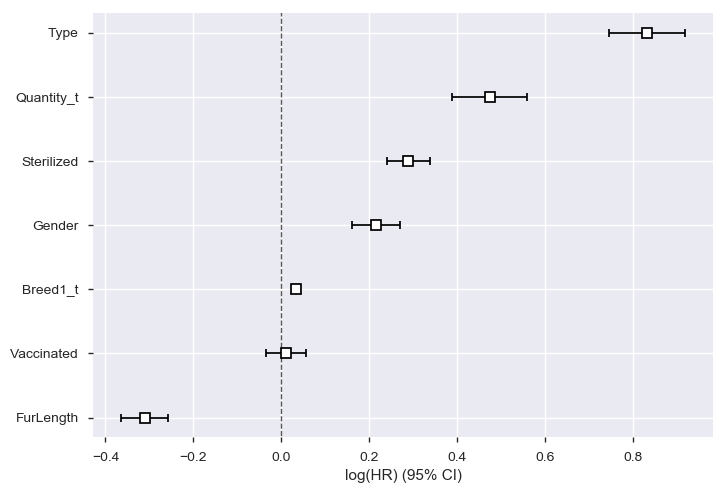

In [147]:
## Coef. Plot for the selected attributes
cph.plot()

In [148]:
# Correlation Matrix Score for this model
print(cph.score_)

0.7201131750392149


In [149]:
## Reference to the Surviver ship models in Python
## https://lifelines.readthedocs.io/en/latest/Survival%20analysis%20with%20lifelines.html

In [150]:
kmf = KaplanMeierFitter()

In [151]:
## Setting up the KaplanMeier Model
T = data_r5["Age"]
E = data_r5["AdoptionSpeed_t2"]

kmf.fit(T, event_observed=E)

<lifelines.KaplanMeierFitter: fitted with 14993 observations, 10796 censored>

Text(0.5, 1.0, 'Survival function of Age on AdoptionSpeed')

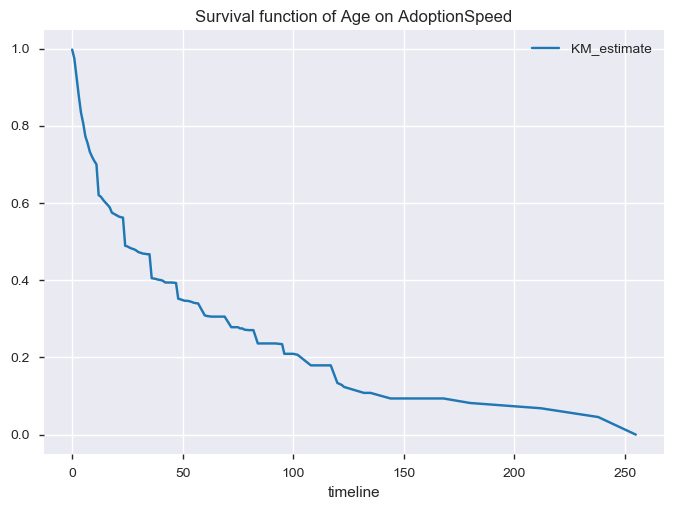

In [152]:
## Printing the Survivorship model in KMF
kmf.survival_function_.plot()
plt.title('Survival function of Age on AdoptionSpeed')

Text(0.5, 1.0, 'Lifespans of Pet Adoption Types for AdoptionSpeed')

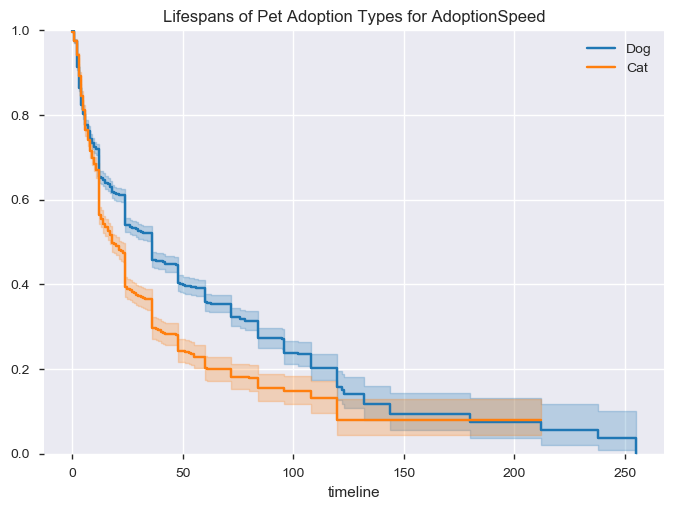

In [153]:
# Plotting the Lifspan for the Type in AdoptionSpeed 
ax = plt.subplot(111)
dem = (data_r5["Type"]==1)

kmf.fit(T[dem], event_observed=E[dem], label="Dog")
kmf.plot(ax=ax)
kmf.fit(T[~dem], event_observed=E[~dem], label="Cat")
kmf.plot(ax=ax)

plt.ylim(0, 1);
plt.title("Lifespans of Pet Adoption Types for AdoptionSpeed")

Iteration 5: norm_delta = 0.00000, step_size = 1.0000, ll = -34271.76107, newton_decrement = 0.00000, seconds_since_start = 0.100Convergence completed after 5 iterations.


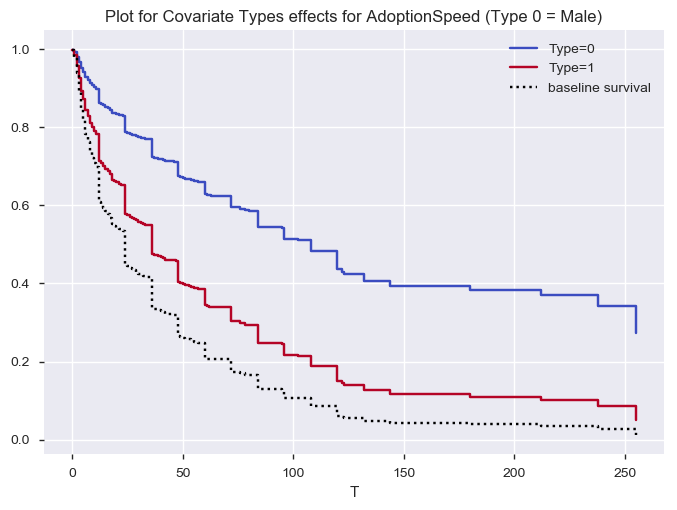

In [154]:
# Plotting the Gender for Suvivership in CoxPHFitter

cph = CoxPHFitter()
cph.fit(data_r5, duration_col='Age', event_col='AdoptionSpeed_t2', show_progress=True)

cph.plot_covariate_groups('Type', [0, 1], cmap='coolwarm')
plt.title("Plot for Covariate Types effects for AdoptionSpeed (Type 0 = Male)")
plt.show()

Text(0.5, 1.0, 'Lifespans of Sterilized or Unsterilized Pets for AdoptionSpeed')

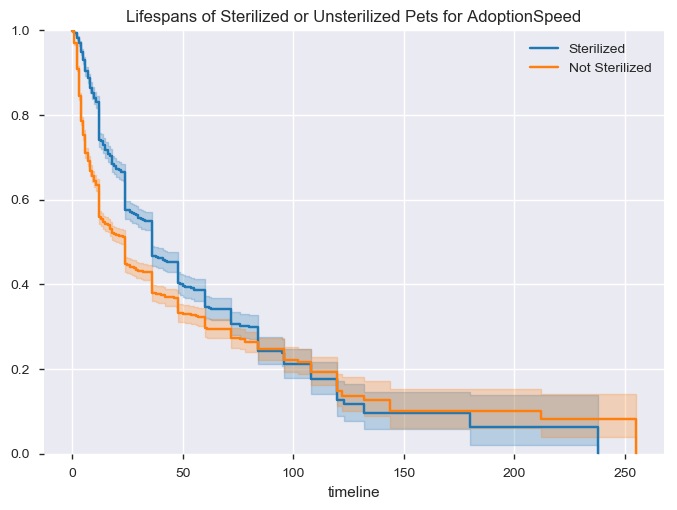

In [155]:
## Printing the Survivorship model in KMF
ax = plt.subplot(111)
dem = (data_r5["Sterilized"]==1)

kmf.fit(T[dem], event_observed=E[dem], label="Sterilized")
kmf.plot(ax=ax)
kmf.fit(T[~dem], event_observed=E[~dem], label="Not Sterilized")
kmf.plot(ax=ax)

plt.ylim(0, 1);
plt.title("Lifespans of Sterilized or Unsterilized Pets for AdoptionSpeed")

In [156]:
#  Hazards Function in Nelson
naf = NelsonAalenFitter()
naf.fit(T,event_observed=E)

<lifelines.NelsonAalenFitter: fitted with 14993 observations, 10796 censored>

          NA_estimate
timeline             
0.0          0.002404
1.0          0.025760
2.0          0.076589
3.0          0.130178
4.0          0.181012


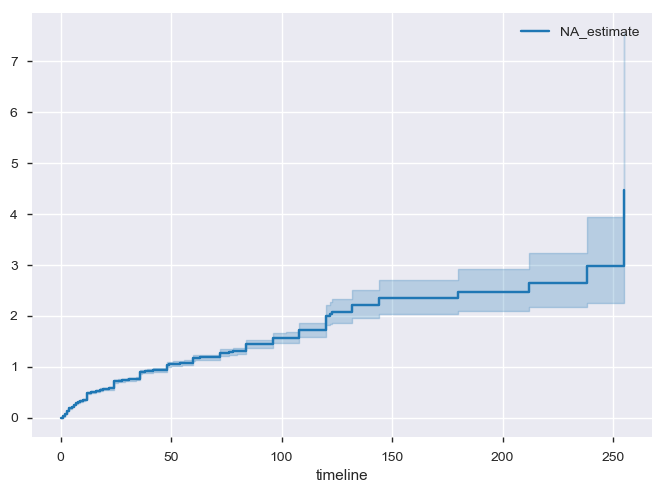

In [157]:
# Printing the cumulative Hazards
print(naf.cumulative_hazard_.head())
naf.plot()

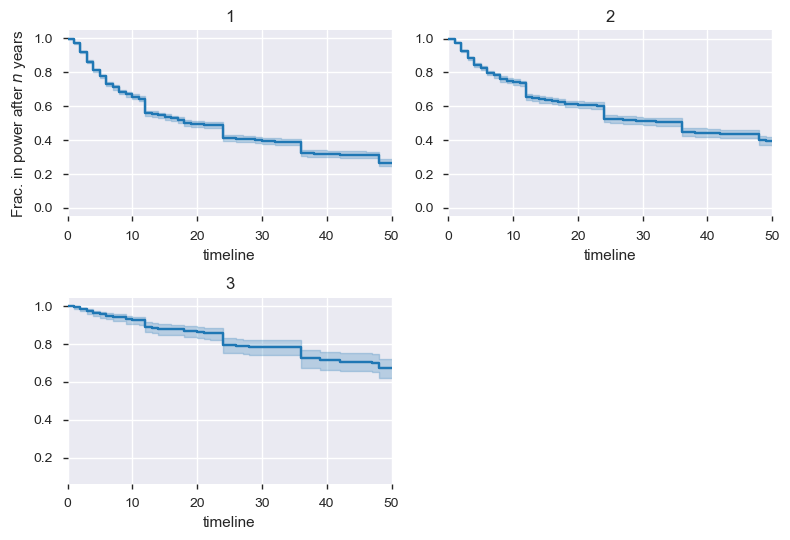

In [158]:
## Printing the change in regime types or FurLength for pet adoption animals
regime_types = data_r5['FurLength'].unique()

for i, regime_type in enumerate(regime_types):
    ax = plt.subplot(2, 2, i + 1)

    ix = data_r['FurLength'] == regime_type
    kmf.fit(T[ix], E[ix], label=regime_type)
    kmf.plot(ax=ax, legend=False)

    plt.title(regime_type)
    plt.xlim(0, 50)

    if i==0:
        plt.ylabel('Frac. in power after $n$ years')
        

plt.tight_layout()

In [159]:
##################### Text Analysis

In [160]:
## Creating another pandas dataframe with three variables for the text analysis
df6 = data_r[['PetID', 'Name', 'AdoptionSpeed']]
df6.head(3)

PetID         Name  AdoptionSpeed
0  86e1089a3       Nibble              2
1  6296e909a  No Name Yet              0
2  3422e4906       Brisco              3

In [161]:
## Checking the variables for the text analysis dataframe
df6.count()

PetID            14993
Name             13736
AdoptionSpeed    14993
dtype: int64

In [162]:
# Removing Missing entries
df7 = df6
df7 = df6.dropna()
df7.shape

(13736, 3)

In [163]:
## Creating the final binned AdoptionSpeed column
df7["AdoptionSpeed_t3"]=df7["AdoptionSpeed"]
data_r.head(1)

Type    Name  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  \
0     2  Nibble    3     299       0       1       1       7       0   

   MaturitySize      ...        Health  Quantity  Fee  State  \
0             1      ...             1         1  100  41326   

                          RescuerID  VideoAmt  \
0  8480853f516546f6cf33aa88cd76c379         0   

                                         Description      PetID PhotoAmt  \
0  Nibble is a 3+ month old ball of cuteness. He ...  86e1089a3      1.0   

   AdoptionSpeed  
0              2  

[1 rows x 24 columns]

In [164]:
## Binnng the AdoptionSpeed attributes to a binary variable.
df7.AdoptionSpeed_t3[df7.AdoptionSpeed == 0] = 0
df7.AdoptionSpeed_t3[df7.AdoptionSpeed == 1] = 0
df7.AdoptionSpeed_t3[df7.AdoptionSpeed == 2] = 0
df7.AdoptionSpeed_t3[df7.AdoptionSpeed == 3] = 1
df7.AdoptionSpeed_t3[df7.AdoptionSpeed == 4] = 1

In [165]:
## Calculating the Text Length of the Names
df7['text length'] = df7['Name'].apply(len)
df7.head()

PetID         Name  AdoptionSpeed  AdoptionSpeed_t3  text length
0  86e1089a3       Nibble              2                 0            6
1  6296e909a  No Name Yet              0                 0           11
2  3422e4906       Brisco              3                 1            6
3  5842f1ff5         Miko              2                 0            4
4  850a43f90       Hunter              2                 0            6

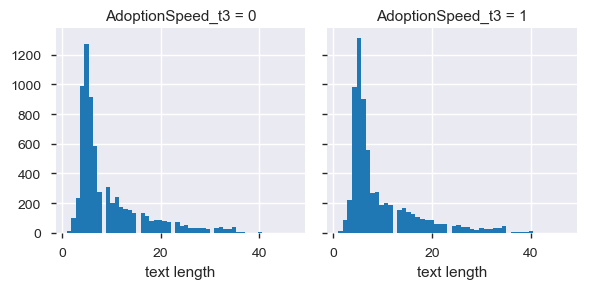

In [166]:
# Histogram comparing the text length to binary adoptionspeed
g = sns.FacetGrid(data=df7, col='AdoptionSpeed_t3')
g.map(plt.hist, 'text length', bins=50)

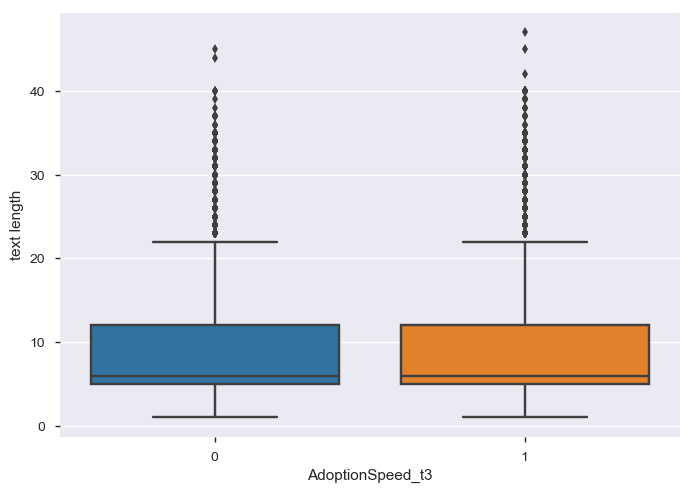

In [167]:
# Box Plot for Text length
sns.boxplot(x='AdoptionSpeed_t3', y='text length', data=df7)

In [168]:
# Calculating the polarity index
df7['polarity'] = df7['Name'].map(lambda text: TextBlob(text).sentiment.polarity)
df7.head(3)

PetID         Name  AdoptionSpeed  AdoptionSpeed_t3  text length  \
0  86e1089a3       Nibble              2                 0            6   
1  6296e909a  No Name Yet              0                 0           11   
2  3422e4906       Brisco              3                 1            6   

   polarity  
0       0.0  
1       0.0  
2       0.0

In [169]:
# Creating text dataframe
text=df7

In [170]:
## Testing Datafram
text.head(3)

PetID         Name  AdoptionSpeed  AdoptionSpeed_t3  text length  \
0  86e1089a3       Nibble              2                 0            6   
1  6296e909a  No Name Yet              0                 0           11   
2  3422e4906       Brisco              3                 1            6   

   polarity  
0       0.0  
1       0.0  
2       0.0

(0.0, 12510.0)

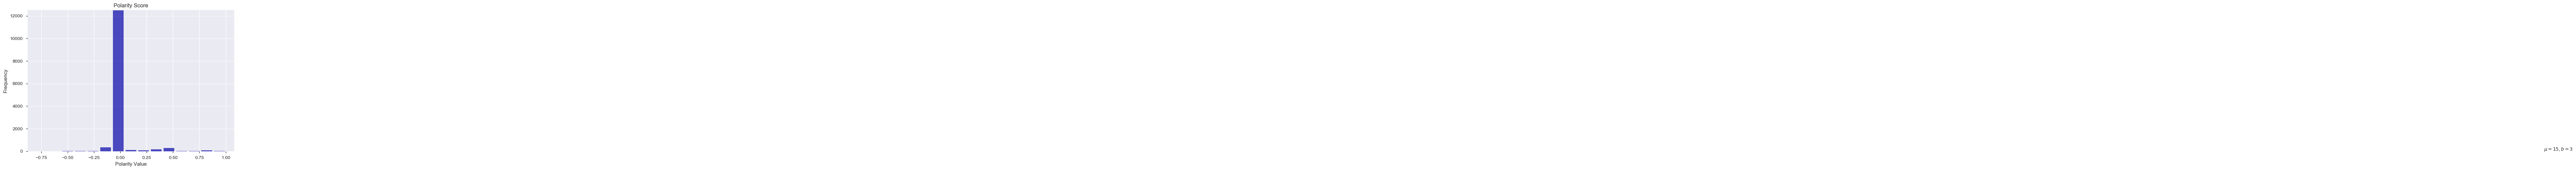

In [171]:
## Histogram with Polarity Score 
n, bins, patches = plt.hist(x=df7.polarity, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Polarity Value')
plt.ylabel('Frequency')
plt.title('Polarity Score')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [172]:
# Calculating the word count for Name
df7['word_count'] = df7['Name'].apply(lambda x: len(str(x).split()))
df7.head(3)

PetID         Name  AdoptionSpeed  AdoptionSpeed_t3  text length  \
0  86e1089a3       Nibble              2                 0            6   
1  6296e909a  No Name Yet              0                 0           11   
2  3422e4906       Brisco              3                 1            6   

   polarity  word_count  
0       0.0           1  
1       0.0           3  
2       0.0           1

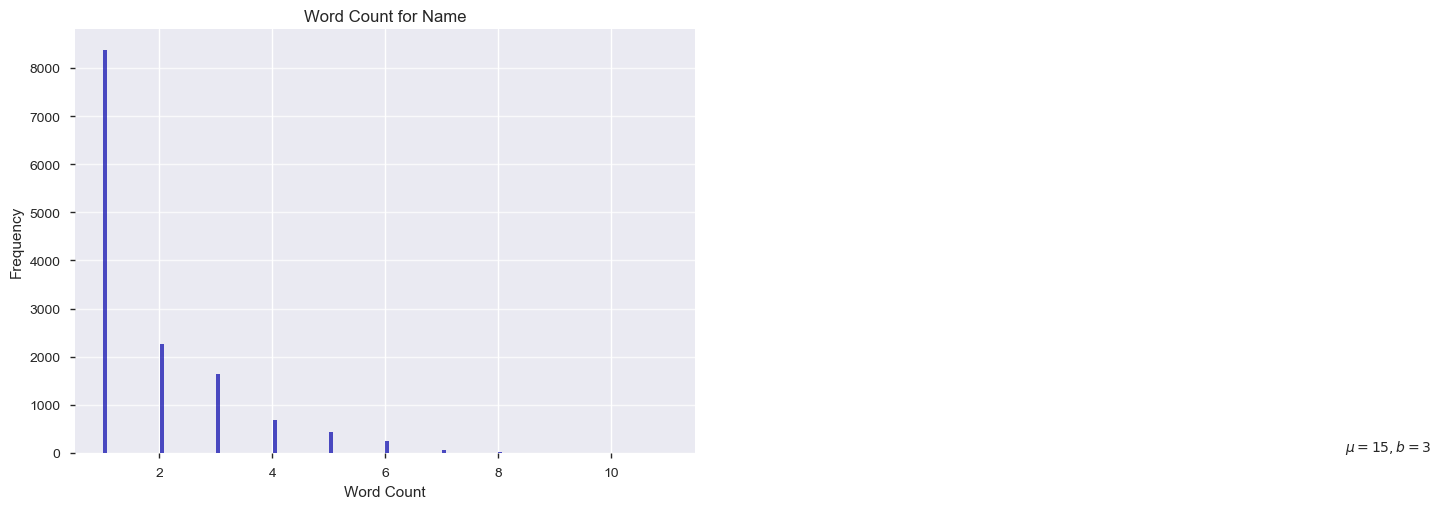

In [173]:
## Histogram with Polarity Score 
n, bins, patches = plt.hist(x=df7.word_count, bins='auto', color='#0504ab',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Word Count for Name')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
# plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [174]:
# Creating another data base for text analysis
df8=df7

In [175]:
analyser = SentimentIntensityAnalyzer()

In [176]:
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(score)))

In [177]:
sentiment_analyzer_scores('The food is good here')

The food is good here------------------- {'neg': 0.0, 'neu': 0.58, 'pos': 0.42, 'compound': 0.4404}


In [178]:
# Trying the new Sentiment Analyzer function for the Name attribute
sentences = df7.Name

analyzer = SentimentIntensityAnalyzer()
for sentence in sentences:
    vs = analyzer.polarity_scores(sentence)
    print("{:-<65} {}".format(sentence, str(vs)))

Nibble----------------------------------------------------------- {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
No Name Yet------------------------------------------------------ {'neg': 0.524, 'neu': 0.476, 'pos': 0.0, 'compound': -0.296}
Brisco----------------------------------------------------------- {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Miko------------------------------------------------------------- {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Hunter----------------------------------------------------------- {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
BULAT------------------------------------------------------------ {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Siu Pak & Her 6 Puppies------------------------------------------ {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Kitty------------------------------------------------------------ {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Bear-----------------------------

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Barker----------------------------------------------------------- {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Blake Jr--------------------------------------------------------- {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Bunny------------------------------------------------------------ {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Rambo------------------------------------------------------------ {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Tazzy------------------------------------------------------------ {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Henry------------------------------------------------------------ {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
In Need Of New Home~--------------------------------------------- {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Max-------------------------------------------------------------- {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Tommy-----------------------------------

In [179]:
# Prerprocessing the Review Text and calcuating the polarity, review length and word count 

df8 = df7[~df7['Name'].isnull()]

def preprocess(Name):
    Name = Name.str.replace("(<br/>)", "")
    Name = Name.str.replace('(<a).*(>).*(</a>)', '')
    Name = Name.str.replace('(&amp)', '')
    Name = Name.str.replace('(&gt)', '')
    Name = Name.str.replace('(&lt)', '')
    Name = Name.str.replace('(\xa0)', ' ') 
    Name = Name.str.replace('(!)', ' ')
    Name = Name.str.replace('("")', ' ')
    Name = Name.str.replace('(', ' ')
    Name = Name.str.replace(')', ' ')
    return Name
df7['Name'] = preprocess(df7['Name'])

df7['polarity'] = df7['Name'].map(lambda text: TextBlob(text).sentiment.polarity)
df7['review_len'] = df7['Name'].astype(str).apply(len)
df7['word_count'] = df7['Name'].apply(lambda x: len(str(x).split()))

In [180]:
# Printing the first five rows with the positive sentiment polarity rating
print('5 random reviews with the highest positive sentiment polarity: \n')
cl = df8.loc[df7.polarity == 1, ['Name']].sample(5).values
for c in cl:
    print(c[0])

5 random reviews with the highest positive sentiment polarity: 

Awesome
Awesome Foursome
FOUR AWESOME
DELIGHTFUL PUPPIES!
BonBon( A Perfect Companion 4 Cat)


In [181]:
# Printing the first five rows with the neutral sentiment polarity rating

print('5 random reviews with the most neutral sentiment(zero) polarity: \n')
cl = df8.loc[df7.polarity == 0, ['Name']].sample(5).values
for c in cl:
    print(c[0])

5 random reviews with the most neutral sentiment(zero) polarity: 

Westie
Tiger Tabby
BB
Rt
Yuki


In [182]:
# Printing the first five rows with the negative sentiment polarity rating

print('5 reviews with the most negative polarity: \n')
cl = df8.loc[df7.polarity == -0.50, ['Name']].sample(5).values
for c in cl:
    print(c[0])

5 reviews with the most negative polarity: 

4 Kittens (1 Blind) & Mummy
Please Adopt 2 Blind Kittens
Nameless
Nameless
Shy / Ruby


In [183]:
## Top 20 Words after the stop words have been removed

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df7['Name'], 20)
for word, freq in common_words:
    print(word, freq)
df8 = pd.DataFrame(common_words, columns = ['Name' , 'count']) 

kittens 324
puppies 300
kitten 276
puppy 227
adoption 215
boy 200
girl 179
baby 166
black 153
cute 144
little 134
white 132
female 125
kitty 124
lucky 101
mix 95
brownie 93
cat 91
home 86
mimi 83


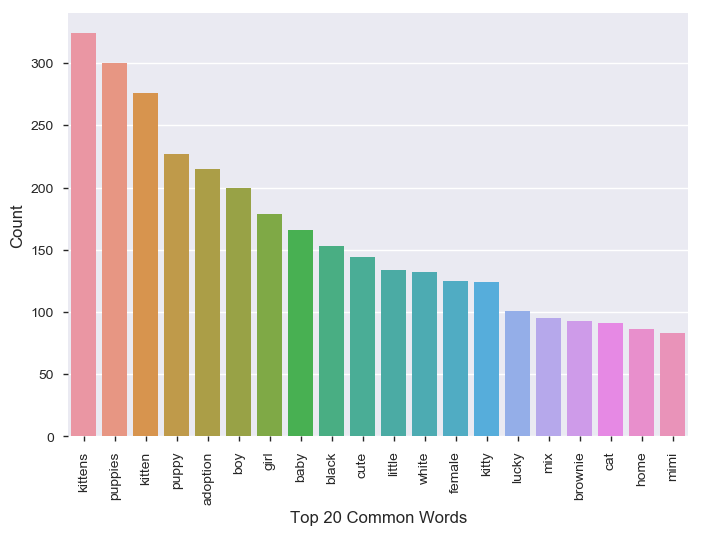

In [184]:
## Bar Graphing the Results after stop words removed
sns.barplot(x="Name", y="count", data=df8) 
plt.ylabel('Count', fontsize=12)
plt.xlabel('Top 20 Common Words', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

In [185]:
df7.head(2)

PetID         Name  AdoptionSpeed  AdoptionSpeed_t3  text length  \
0  86e1089a3       Nibble              2                 0            6   
1  6296e909a  No Name Yet              0                 0           11   

   polarity  word_count  review_len  
0       0.0           1           6  
1       0.0           3          11

In [186]:
# Setting up the Text Analysis for Naive Bayes Model
X = text['Name']
y = text['AdoptionSpeed_t3']

In [187]:
# Preprocessing step for the removal of punctuation, stopwords and converting to lower case words
import string
def text_process(text):
    '''
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Return the cleaned text as a list of words
    '''
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.split() if word.lower() not in 
    stopwords.words('english')]

In [188]:
# Testing the preprocessing step.  
sample_text = "Hey there! This is a sample review, which happens to contain punctuations."
print(text_process(sample_text))

['Hey', 'sample', 'review', 'happens', 'contain', 'punctuations']


In [189]:
# Setting up the bow transformer method for sparse datasets 
bow_transformer = CountVectorizer(analyzer=text_process).fit(X)

In [190]:
# Printing the length of the bow transformed vocabulary
len(bow_transformer.vocabulary_)

7271

In [191]:
# Checking the 25 value in the matrix for X
review_25 = X[24]
review_25

'Cikenet'

In [192]:
# Initiating the Bow Tranformation of X
X = bow_transformer.transform(X)

In [193]:
# Pringint the Sparse, dense and amount of non zero occurances
print('Shape of Sparse Matrix: ', X.shape)
print('Amount of Non-Zero occurrences: ', X.nnz)
# Percentage of non-zero values
density = (100.0 * X.nnz / (X.shape[0] * X.shape[1]))
print('Density: {}'.format((density)))

Shape of Sparse Matrix:  (13736, 7271)
Amount of Non-Zero occurrences:  21850
Density: 0.021877465845721353


In [194]:
# Splitting the data for a 70 to 30 split between training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [195]:
# Using the NB Model to begin text analysis
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [196]:
# Predictinon Model for NB
preds = nb.predict(X_test)

In [197]:
# Calculating and printing confusion matrix
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.52      0.66      0.58      2075
           1       0.53      0.39      0.45      2046

   micro avg       0.52      0.52      0.52      4121
   macro avg       0.52      0.52      0.51      4121
weighted avg       0.52      0.52      0.51      4121



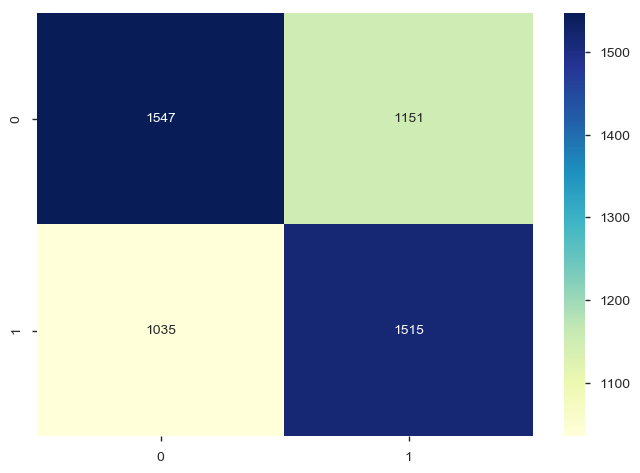

In [198]:
# visualize confusion matrix with seaborn library
sns.heatmap(confusion_matrix,annot=True,fmt="d",  cmap="YlGnBu")
plt.show()

In [199]:
# Printing the Naive Bayes Classifier Accuracy Score
print('Accuracy of Naive Bayes classifier on test set: {:.2f}'.format(nb.score(X_test, y_test)))

Accuracy of Naive Bayes classifier on test set: 0.52
